# Document Overview
Created on 10/14/2019 by Cong Zhang

Step 1: read the raw DMP files, and aggregate the file to OpenEI building types

Step 2: Map the zip/building type to the weatherstation ID, then build the system level load

    2.1: work on the commercial building load
    
    2.2: work on the residential building load
Step 3: Read in the EIA data, and ranking the load for the commercial and residential load based on the EIA 2016 data ranking

In [1]:
import difflib
import string
import pandas as pd
import copy
import math
import numpy as np
from numpy import median
import os
import datetime
from Manipulate import extract_datetime_8760
import matplotlib
import glob
import re
import matplotlib.pyplot as plt
from functools import reduce
import time
from heapq import nsmallest
import seaborn as sns
%matplotlib inline

In [2]:
start1 = datetime.datetime.now()

In [3]:
Switch_monthlyScaling = 1 #(montly scaling)

Region_list = ['CA','TX','NewEngland','MA']
region_id = 0  #0,1,2,3

Switch_res_calculation = 1 #0: deactivate for residential  0: activate for residential 
for region_index in range(region_id,region_id+1):
    Region = Region_list[region_index]
    print('====The current state is ' + Region + ' ====')
Switch_year2016 = 1
Switch_res_ranking = 0
Switch_com_ranking = 1
Switch_EEconsidered = 1 # Revise the EE of end use


Switch_DayTimeScaling = 1
# 1- Only use the day time load to scale
# 0- Use all 24 hour data
Switch_daylight = Switch_DayTimeScaling #1- Only scale the daylight time, 6-22, the load value is 0 in other time period

Switch_usingResStock_test = 3
# 3- Using the updated test size data:  LBNL run results.csv
# 2- Using the full size data:  LBNL run results.csv
# 1- Using ResStock test data: Test12_perbldgresults.csv
# 0- Using the demo data:  Nov15_baseline_selected_locs.csv

Switch_usingComStock_test = 1
# 0- Using the OpenEI data
# 1- Using the 8760_dry_run

upgrade_Base = 0  
upgrade_EE = 5 
Keyword2 = 'scenario_0_VS_5'
## EE scenario: 0-base  1-5 EE
key_string = 'tot_cond_ft_2_mean' # Choose the key words, which is used for the scaling factor of the area scaling

switch_USacross = 2 #1- match the IECC across the whole US  0- match the IECC across the state, if not, choose the enarest WS

Switch_ReadERCO_CMAX_hourly= 1 # Read ERCOT info, data source-https://www.eia.gov/beta/states/states/tx/data/dashboard/electricity

Switch_compare = 1

====The current state is CA ====


# 1. Build the system load - Commercial

In [4]:
def AverageToLeapYear(load_list):
    a = load_list[0:24*59]
    b = load_list[24*58:24*59]
    c = load_list[24*59:]
    load_list_new = a+b+c
    return load_list_new

In [14]:
if Switch_usingComStock_test == 1:
    for name_label in ['Baseline-8760_v4','Upgrade_Roof_Insulation_R_30_-8760_v4','Add_Lighting_Occupancy_Controls-8760_v4','Upgrade_RTU_DX_Air_Conditioner_IEER_17_0_-8760_v4']:    
        print('====== Now launch the scenario: '+name_label + '========')
        count_1 = 0
        count_2 = 0
        #load the aggregated DMP data
        df_building_agg_WSBT_typeReplaced = pd.read_csv('Outputs/s5_'+ Region +'_commercial_locally_afterMapAggregate_WSID.csv')
        factor_count = df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (Raw) Remove Exclude']/(df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (WithoutNan_ZipBSqft_EXCLUDE)'])
        wsid_unique_dmp = df_building_agg_WSBT_typeReplaced['Matched weather station'].unique().tolist()

        #load buiding type summary
        df_OpenEI_summary = pd.read_csv('Inputs/OpenEI_model.csv')

        # Read in the ComStock data
        df_ComStock_dry8760 = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/' + name_label+'.csv')

        df_weatherstation_formatsMapping = pd.read_csv('Inputs/Mapping_NREL_City_formats.csv')

        df_comstock_mapping = pd.read_csv('Inputs/comstock_weather_mapping.csv')    
        ComStock_Weather_File_list = df_comstock_mapping['ComStock Weather File'].tolist()
        weather_station_id_list = [x[-15:-9] for x in ComStock_Weather_File_list]
        df_comstock_mapping['weather_station_id(ComStock_Format)'] = weather_station_id_list

        df_system_com = pd.DataFrame()
        for i in range(0,len(wsid_unique_dmp)):
            if i == int(0.2*len(wsid_unique_dmp)) or i == int(0.6*len(wsid_unique_dmp)):
                print('Now is launching the '+ str(i)+ '/(' + str(len(wsid_unique_dmp)) + ')')
            try:
                wsid_index = weather_station_id_list.index(str(wsid_unique_dmp[i]))
                ComStock_Weather_File = ComStock_Weather_File_list[wsid_index]
                print('    In processing for WS file:' + ComStock_Weather_File)
                df_ComStock_dry8760_sameWS = df_ComStock_dry8760[df_ComStock_dry8760['weather_station']==ComStock_Weather_File]
                df_statistic_sameWSid = df_building_agg_WSBT_typeReplaced[df_building_agg_WSBT_typeReplaced['Matched weather station']== int(wsid_unique_dmp[i])]
                for j in range(0,len(df_statistic_sameWSid)):

                    keyword_loadfile_raw = df_statistic_sameWSid.iloc[j]['Mapped OpenEI building type']
                    keyword_loadfile =  df_statistic_sameWSid.iloc[j]['Mapped OpenEI building type new']
                    file_full_dir = [x for x in datafile_list if keyword_loadfile in x]
                    index_id = list(df_OpenEI_summary['BUILDING TYPE NAME']).index(keyword_loadfile_raw)
                    factor_area = df_statistic_sameWSid.iloc[j]['TotalBuildingSqft']/(list(df_OpenEI_summary['FLOOR AREA (FT2)'])[index_id])

                    # read the csv file

                    if keyword_loadfile =='Stand-aloneRetail':
                        keyword_loadfile = 'RetailStandalone'
                    elif keyword_loadfile =='StripMall':
                        keyword_loadfile = 'RetailStripmall'                    
                    elif keyword_loadfile =='MidriseApartment':
                        continue
                    elif keyword_loadfile =='SuperMarket':
                        continue
                    if keyword_loadfile in df_ComStock_dry8760_sameWS['building_type'].unique().tolist():
                        unit_load = df_ComStock_dry8760_sameWS[df_ComStock_dry8760_sameWS['building_type']==keyword_loadfile]
    #                     df_statistic_sameWSid_BT = df_statistic_sameWSid[df_statistic_sameWSid['']== (df_statistic_sameWSid.iloc[j]['Mapped OpenEI building type new'])]
                        count_2 = count_2+factor_area
                        print('        factor_area is: '+str(factor_area))
                        if count_1 ==0:
                            df_system_com = unit_load.copy()
                            count_1 = count_1+1
                        unit_column_list = unit_load.columns.tolist()[1:15]
                        for k in unit_column_list:
                            unit_load[k] = [x*factor_area*factor_count for x in unit_load[k]]
                            if k in df_system_com.columns:
                                df_system_com[k] = list(map(lambda x: x[0]+x[1], zip(df_system_com[k], unit_load[k])))
                            else:
                                df_system_com[k] = unit_load[k]
            except:
                pass

        systemload_list_commercial = df_system_com['out.electricity.total.energy_consumption'].tolist()
        systemload_list_commercial_leap = AverageToLeapYear(systemload_list_commercial)

        df_system_com_scale = df_system_com.copy()
        factor_count2 = (df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (WithoutNan_ZipBSqft_EXCLUDE)'])/count_2
        unit_column_list = df_system_com_scale.columns.tolist()[1:15]
        for k in unit_column_list:
            df_system_com_scale[k] = [x*factor_count2/10000000 for x in df_system_com_scale[k]]
            
        if name_label =='Baseline-8760_v4':
            df_system_com_scale_base = df_system_com_scale.copy()
        elif name_label =='Upgrade_Roof_Insulation_R_30_-8760_v4':
            df_system_com_scale_upadtedR30 = df_system_com_scale.copy()            
        elif name_label =='Add_Lighting_Occupancy_Controls-8760_v4':
            df_system_com_scale_upadtedlighting = df_system_com_scale.copy()   
        elif name_label =='Upgrade_RTU_DX_Air_Conditioner_IEER_17_0_-8760_v4':
            df_system_com_scale_upadtedAC = df_system_com_scale.copy()     
        else:
            print('***************** error ************')

====== Now launch the scenario: Baseline-8760_v4========
    In processing for WS file:USA_CA_Sacramento.Intl.724839_2012.epw
    In processing for WS file:USA_CA_San.Francisco.Intl.724940_2012.epw
    In processing for WS file:USA_CA_Barstow.Daggett.723815_2012.epw
Now is launching the 14/(73)
    In processing for WS file:USA_TX_Wichita.Falls.Sheps.723510_2012.epw
    In processing for WS file:USA_CA_Fresno.Air.Terminal.723890_2012.epw
    In processing for WS file:USA_CA_Burbank.Glendale.722880_2012.epw
    In processing for WS file:USA_CA_Bakersfield.Meadows.723840_2012.epw
    In processing for WS file:USA_CA_Camarillo.723926_2012.epw
Now is launching the 43/(73)
    In processing for WS file:USA_CA_Santa.Barbara.Muni.723925_2012.epw
    In processing for WS file:USA_CA_Arcata.725945_2012.epw


KeyError: 'out.electricity.total.energy_consumption'

In [10]:
df_ComStock_dry8760_sameWS
df_statistic_sameWSid

NameError: name 'df_statistic_sameWSid' is not defined

In [7]:
df_system_com
keyword_loadfile

NameError: name 'keyword_loadfile' is not defined

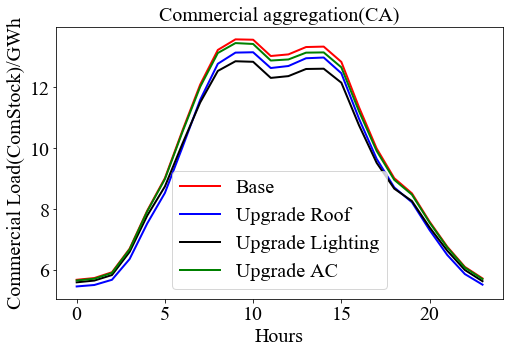

In [168]:
title_name = 'Commercial aggregation('+Region+ ')'
figsize = 8,5
figure, ax = plt.subplots(figsize=figsize)

hours= [x for x in range(0,24)]


A,=plt.plot(hours,df_system_com_scale_base.groupby('hour').mean()['out.electricity.total.energy_consumption'],'-r',label='Base',linewidth=2.0)
B,=plt.plot(hours,df_system_com_scale_upadtedR30.groupby('hour').mean()['out.electricity.total.energy_consumption'],'-b',label='Upgrade Roof',linewidth=2.0)
C,=plt.plot(hours,df_system_com_scale_upadtedlighting.groupby('hour').mean()['out.electricity.total.energy_consumption'],'-k',label='Upgrade Lighting',linewidth=2.0)
D,=plt.plot(hours,df_system_com_scale_upadtedAC.groupby('hour').mean()['out.electricity.total.energy_consumption'],'-g',label='Upgrade AC',linewidth=2.0)

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
# legend = plt.legend(handles=[A,B,C,D],prop=font1, bbox_to_anchor=[1.04,1])
legend = plt.legend(handles=[A,B,C,D],prop=font1)

plt.tick_params(labelsize=20)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.xlabel('Hours',font2)
plt.ylabel('Commercial Load(ComStock)/GWh',font2)
plt.title(title_name,font1) 
# plt.xticks([1, 3, 5,7,9,11])
plt.show()

In [16]:
Switch_usingComStock_test = 0
if Switch_usingComStock_test == 1:
    pass
elif Switch_usingComStock_test == 0:
    #load the aggregated DMP data
    df_building_agg_WSBT_typeReplaced = pd.read_csv('Outputs/s5_'+ Region +'_commercial_locally_afterMapAggregate_WSID.csv')
    factor_count = df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (Raw) Remove Exclude']/(df_building_agg_WSBT_typeReplaced.iloc[0]['All Count # (WithoutNan_ZipBSqft_EXCLUDE)'])

    #load buiding type summary
    df_OpenEI_summary = pd.read_csv('Inputs/OpenEI_model.csv')
    # Begin to calculate the system level commercial load
    systemload_list = list(np.zeros(8760))
    # Query the OpenEI commercial load
    data_direi = r'../Shared Drives/BTO Topic 2  Integrating EE & DR/Task 2/Load_Shape_Data/OPEN_EI/*'
    files = glob.glob(data_direi)
    wsid_unique_dmp = df_building_agg_WSBT_typeReplaced['Matched weather station'].unique().tolist()

    df_system_com = pd.DataFrame()
    for i in range(0,len(wsid_unique_dmp)):
        if i == int(0.2*len(wsid_unique_dmp)) or i == int(0.6*len(wsid_unique_dmp)):
            print('Now is launching the '+ str(i)+ '/(' + str(len(wsid_unique_dmp)) + ')')

        WSid_str = str(wsid_unique_dmp[i])
        df_sameWSid = df_building_agg_WSBT_typeReplaced[df_building_agg_WSBT_typeReplaced['Matched weather station']== int(WSid_str)]

        folder_dir = [x for x in files if WSid_str in x]
        datafile_list = glob.glob(folder_dir[0]+'/*')    
        for j in range(0,len(df_sameWSid)):

            keyword_loadfile_raw = df_sameWSid.iloc[j]['Mapped OpenEI building type']
            keyword_loadfile =  df_sameWSid.iloc[j]['Mapped OpenEI building type new']
            file_full_dir = [x for x in datafile_list if keyword_loadfile in x]
            index_id = list(df_OpenEI_summary['BUILDING TYPE NAME']).index(keyword_loadfile_raw)
            factor_area = df_sameWSid.iloc[j]['TotalBuildingSqft']/(list(df_OpenEI_summary['FLOOR AREA (FT2)'])[index_id])

            # read the csv file
            unit_load = pd.read_csv(file_full_dir[0])

            if i ==0 and j==0:
                df_system_com['Date/Time'] = unit_load['Date/Time'].tolist()

            unit_column_list = unit_load.columns.tolist()[1:]
            for k in unit_column_list:
                unit_load[k] = [x*factor_area*factor_count for x in unit_load[k]]
                if k in df_system_com.columns:
                    df_system_com[k] = list(map(lambda x: x[0]+x[1], zip(df_system_com[k], unit_load[k])))
                else:
                    df_system_com[k] = unit_load[k]
    systemload_list_commercial = df_system_com['Electricity:Facility [kW](Hourly)'].tolist()
    systemload_list_commercial_leap = AverageToLeapYear(systemload_list_commercial)

Now is launching the 14/(73)
Now is launching the 43/(73)


# 2. Build the system load - Residential

In [7]:
df_ScalingFactor = pd.read_csv('For_ScalingFactor_begin.csv')
# Scale_UsableRatio,  Scale_BuildingCount,  Scale_EIARefer

In [8]:
if Switch_usingResStock_test ==0:
    df_resstock_raw = pd.read_csv(r'../Shared Drives/GEB Potential Study (NREL_LBNL)/Nov15_baseline_selected_locs.csv')
    # Downsample the raw NREL data, from 15 minutes to 1 hour
    columns_list = df_resstock_raw.columns.tolist()
    df_resstock = pd.DataFrame()

    for i in range(len(columns_list)):
        if i<=1 or i>=38:
            tem_column = [x for x in df_resstock_raw[columns_list[i]].tolist()[3::4]]
        else:
            column_value_list = df_resstock_raw[columns_list[i]].tolist()
            tem_column = []
            for j in range(0,len(column_value_list),4):
    #             tem_column.append(sum(column_value_list[j:j+4]))
                tem_column.append(np.mean(column_value_list[j:j+4]))
        df_resstock[columns_list[i]] =  tem_column
        
elif Switch_usingResStock_test ==1:
    df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_Test/Test12_perbldgresults.csv')
elif Switch_usingResStock_test ==2:
    df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_0306/LBNL run results.csv')    
elif Switch_usingResStock_test ==3:
    df_resstock = pd.read_csv('../Shared Drives/NREL_ResStock_0507/Revamp Test Run.csv')  

In [9]:
#load the residential data

# df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary.csv')
if switch_USacross ==1:
    df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary_new_USMatch.csv')
elif switch_USacross ==0:
    df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary_new_StateMatch.csv')
elif switch_USacross ==2:
    df_resstock_number = pd.read_csv('Outputs/S6_'+ Region +'_Residential_summary_new_RMsubregions.csv') 
    if Switch_usingResStock_test ==2:
        result_average_sqft_detail = pd.read_csv('Inputs/AverageSQFT_summary_ResStock_full_0306.csv')
    if Switch_usingResStock_test ==3:
        result_average_sqft_detail = pd.read_csv('Inputs/AverageSQFT_summary_ResStock_test_0507.csv')
    
if Switch_usingResStock_test ==0:
    df_ResStock_weatherstation = pd.read_csv('Inputs/ResStock 2012 AMYs (splited).csv')
elif Switch_usingResStock_test >=1:    
    df_ResStock_weatherstation = pd.read_csv('Inputs/Mapping_NREL_City_formats.csv')
    ID1_list = df_ResStock_weatherstation['ID1'].tolist()
    epw_list = df_ResStock_weatherstation['epw'].tolist()
    USAF_list = df_ResStock_weatherstation['USAF'].tolist()

scale_factor_usable_raw = df_resstock_number.iloc[0]['All raw number_RmExclude']/(df_resstock_number['Count_EachWS_RMExclude_RMNaNzip_RMunmatched'].sum())

In [10]:
scale_usable = [scale_factor_usable_raw for x in range(len(df_ScalingFactor))]
df_ScalingFactor['Scale_UsableRatio'] = scale_usable

In [11]:
scale_count = [0 for x in range(len(df_ScalingFactor))]
df_system_res = pd.DataFrame()

for i in range(len(df_resstock_number)):
#     print(i)
    station_id = df_resstock_number.loc[i]['Weather Station id']
    if station_id == 120110:
        print(str(station_id)+' is replaced by the ')
        station_id =101017   
        print(str(station_id))
    elif station_id == 210592:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))
    elif station_id == 749293:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))        
        
    if station_id == 111111:
        continue
    elif station_id == 142626:
        print(str(station_id)+' is replaced by the ')
        station_id =165368   
        print(str(station_id))
    elif station_id == 247402:
        print(str(station_id)+' is replaced by the ')
        station_id =215768
        print(str(station_id))
    elif station_id == 368181:
        print(str(station_id)+' is replaced by the ')
        station_id =268333
        print(str(station_id))
    elif station_id == 434720:
        print(str(station_id)+' is replaced by the ')
        station_id =544930
        print(str(station_id))
    elif station_id == 742491:
        print(str(station_id)+' is replaced by the ')
        station_id =753608
        print(str(station_id))
    elif station_id == 766075:
        print(str(station_id)+' is replaced by the ')
        station_id =721297   
        print(str(station_id))
        
    # Translate the format from data 0 to data 1
    index_file = ID1_list.index(station_id)
    epw = epw_list[index_file]
    df_resstock_same_stationid = df_resstock[df_resstock['epw']==epw]
    unique_bt_list = df_resstock_same_stationid['unit_type'].unique().tolist()
    ut_name = df_resstock_number.loc[i]['Mapped OpenEI building type']
    
    tem_a = result_average_sqft_detail[result_average_sqft_detail['weather_station']==epw]
    if ut_name in unique_bt_list:
        df_resstock_epw_ut = df_resstock_same_stationid[df_resstock_same_stationid['unit_type']==ut_name]
        df_resstock_epw_ut = df_resstock_epw_ut[df_resstock_epw_ut['upgrade']==upgrade_Base]
        if Switch_usingResStock_test ==1 or Switch_usingResStock_test == 0:
            scale_factor = df_resstock_number.iloc[i]['Count_EachWS_RMExclude_RMNaNzip_RMunmatched']
        elif Switch_usingResStock_test ==2 or Switch_usingResStock_test ==3:
            temm_total_sqft = df_resstock_number.iloc[i]['BUILDING_SQFT_sum']
            
            tem_b = tem_a[tem_a['building_type']==ut_name]
            average_sqft = tem_b.iloc[0][key_string]
            scale_factor = temm_total_sqft/average_sqft
        
        tem_a = df_ScalingFactor[df_ScalingFactor['epw']== epw]
        list_id = (tem_a[tem_a['unit_type']==ut_name].index).tolist()[0]
        scale_count[list_id]=scale_count[list_id]+scale_factor
    
        if i ==0:
            df_system_res['epw'] = df_resstock_epw_ut['epw'].tolist()
            df_system_res['time'] = df_resstock_epw_ut['time'].tolist()

        unit_column_list = df_resstock_epw_ut.columns.tolist()[4:6]
        for k in unit_column_list:              
            df_resstock_epw_ut[k] = [x*scale_factor*scale_factor_usable_raw for x in df_resstock_epw_ut[k]]

            if k in df_system_res.columns:
                df_system_res[k] = list(map(lambda x: x[0]+x[1], zip(df_system_res[k].tolist(), df_resstock_epw_ut[k].tolist())))
            else:
                df_system_res[k] = df_resstock_epw_ut[k].tolist()
    else:
        print('DMP data does not have the building type (' + df_resstock_number.loc[i]['Mapped OpenEI building type'] + ') for station:('+str(station_id) + ')')
               
systemload_list_residential  = df_system_res['Building_Electricity'].tolist()

df_ScalingFactor['Scale_BuildingTot_area'] = scale_count

DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1299055)
DMP data does not have the building type (Mobile Home) for station:(1272835)
DMP data does not have the building type (Mobile Home) for station:(1314625)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1314625)
DMP data does not have the building type (Mobile Home) for station:(1259614)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1259614)
DMP data does not have the building type (Mobile Home) for station:(1327892)
DMP data does not have the building type (Mobile Home) for station:(1239413)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1239413)
DMP data does not have the building type (Multi-Family with 2 - 4 Units) for station:(1351103)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1351103)
DMP data does not have the building type (Mobile Home) for s

In [12]:
# Calculate the EE scenario
scale_count = [0 for x in range(len(df_ScalingFactor))]
df_system_res = pd.DataFrame()

for i in range(len(df_resstock_number)):
#     print(i)
    station_id = df_resstock_number.loc[i]['Weather Station id']
    if station_id == 120110:
        print(str(station_id)+' is replaced by the ')
        station_id =101017   
        print(str(station_id))
    elif station_id == 210592:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))
    elif station_id == 749293:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))        
        
    if station_id == 111111:
        continue
    elif station_id == 142626:
        print(str(station_id)+' is replaced by the ')
        station_id =165368   
        print(str(station_id))
    elif station_id == 247402:
        print(str(station_id)+' is replaced by the ')
        station_id =215768
        print(str(station_id))
    elif station_id == 368181:
        print(str(station_id)+' is replaced by the ')
        station_id =268333
        print(str(station_id))
    elif station_id == 434720:
        print(str(station_id)+' is replaced by the ')
        station_id =544930
        print(str(station_id))
    elif station_id == 742491:
        print(str(station_id)+' is replaced by the ')
        station_id =753608
        print(str(station_id))
    elif station_id == 766075:
        print(str(station_id)+' is replaced by the ')
        station_id =721297   
        print(str(station_id))
        
    # Translate the format from data 0 to data 1
    index_file = ID1_list.index(station_id)
    epw = epw_list[index_file]
    df_resstock_same_stationid = df_resstock[df_resstock['epw']==epw]
    unique_bt_list = df_resstock_same_stationid['unit_type'].unique().tolist()
    ut_name = df_resstock_number.loc[i]['Mapped OpenEI building type']
    
    tem_a = result_average_sqft_detail[result_average_sqft_detail['weather_station']==epw]
    if ut_name in unique_bt_list:
        df_resstock_epw_ut = df_resstock_same_stationid[df_resstock_same_stationid['unit_type']==ut_name]
        df_resstock_epw_ut = df_resstock_epw_ut[df_resstock_epw_ut['upgrade']==upgrade_EE]
        if Switch_usingResStock_test ==1 or Switch_usingResStock_test == 0:
            scale_factor = df_resstock_number.iloc[i]['Count_EachWS_RMExclude_RMNaNzip_RMunmatched']
        elif Switch_usingResStock_test ==2 or Switch_usingResStock_test ==3:
            temm_total_sqft = df_resstock_number.iloc[i]['BUILDING_SQFT_sum']
            
            tem_b = tem_a[tem_a['building_type']==ut_name]
            average_sqft = tem_b.iloc[0][key_string]
            scale_factor = temm_total_sqft/average_sqft
        
        tem_a = df_ScalingFactor[df_ScalingFactor['epw']== epw]
        list_id = (tem_a[tem_a['unit_type']==ut_name].index).tolist()[0]
        scale_count[list_id]=scale_count[list_id]+scale_factor
    
        if i ==0:
            df_system_res['epw'] = df_resstock_epw_ut['epw'].tolist()
            df_system_res['time'] = df_resstock_epw_ut['time'].tolist()

        unit_column_list = df_resstock_epw_ut.columns.tolist()[4:6]
        for k in unit_column_list:              
            df_resstock_epw_ut[k] = [x*scale_factor*scale_factor_usable_raw for x in df_resstock_epw_ut[k]]

            if k in df_system_res.columns:
                df_system_res[k] = list(map(lambda x: x[0]+x[1], zip(df_system_res[k].tolist(), df_resstock_epw_ut[k].tolist())))
            else:
                df_system_res[k] = df_resstock_epw_ut[k].tolist()
    else:
        print('DMP data does not have the building type (' + df_resstock_number.loc[i]['Mapped OpenEI building type'] + ') for station:('+str(station_id) + ')')
               
systemload_list_residential_EE = df_system_res['Building_Electricity'].tolist()

DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1299055)
DMP data does not have the building type (Mobile Home) for station:(1272835)
DMP data does not have the building type (Mobile Home) for station:(1314625)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1314625)
DMP data does not have the building type (Mobile Home) for station:(1259614)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1259614)
DMP data does not have the building type (Mobile Home) for station:(1327892)
DMP data does not have the building type (Mobile Home) for station:(1239413)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1239413)
DMP data does not have the building type (Multi-Family with 2 - 4 Units) for station:(1351103)
DMP data does not have the building type (Multi-Family with 5+ Units) for station:(1351103)
DMP data does not have the building type (Mobile Home) for s

## 3. Build the dataframe which contains the commercial and residential

In [13]:
systemload_list_com_res = list(map(lambda x: x[0]+x[1], zip(systemload_list_commercial_leap, systemload_list_residential)))

systemload2 = pd.DataFrame()
dt1 = pd.date_range(start="20160101", end="20170102", freq="H")  # freq="D"表示频率为每一天
dt1 = dt1[0:-1]
systemload2['Date/Time']= dt1

systemload = pd.DataFrame()
systemload = systemload2.iloc[1:8785]
systemload.index = range(len(systemload))

hourfield = 'hour'
year = 2016
systemload = systemload.reset_index().rename({'index':'hour'}, axis=1)
systemload['hour'] = systemload['hour']+1
systemload['hour'] = systemload['hour'].astype(float)
systemload['day_of_year'] = np.ceil(systemload[hourfield]/24).astype(int)
dt = datetime.datetime(year,1,1,0,0)
systemload['date'] = dt
for ind in systemload.index:
    hours=systemload.loc[ind, hourfield]-1
    dtdelta = datetime.timedelta(hours = hours)
    systemload.loc[ind,'date'] = dt+dtdelta
systemload['month'] = systemload['date'].dt.month        
# systemload.drop('Date/Time', axis=1, inplace=True)
systemload['weekend'] = systemload['date'].dt.weekday>4
systemload['hour'] = systemload['date'].dt.hour

systemload['commercial_load_kwh'] = systemload_list_commercial_leap
systemload['residential_load_kwh'] = systemload_list_residential
systemload['ComAndRes_load_kwh'] =systemload_list_com_res

if Switch_EEconsidered ==1:
    systemload['residential_load_kwh_EE'] = systemload_list_residential_EE

In [14]:
systemload_test = systemload.copy()
systemload_raw = systemload.copy()
    
if Switch_daylight == 1:    
    hourlist = systemload_test['hour'].tolist()
    commercial_load_kwh_list = systemload_test['commercial_load_kwh'].tolist()
    residential_load_kwh_list = systemload_test['residential_load_kwh'].tolist()
    ComAndRes_load_kwh_list = systemload_test['ComAndRes_load_kwh'].tolist()
    if Switch_EEconsidered ==1:
        residential_load_kwh_list_EE = systemload_test['residential_load_kwh_EE'].tolist()

    for i in range(len(hourlist)):
        if 7<=hourlist[i] and hourlist[i] <=21:
            pass
        else:
            commercial_load_kwh_list[i] = 0
            residential_load_kwh_list[i] = 0
            ComAndRes_load_kwh_list[i] = 0
            if Switch_EEconsidered ==1:
                residential_load_kwh_list_EE[i] = 0

    systemload_test['commercial_load_kwh'] = commercial_load_kwh_list
    systemload_test['residential_load_kwh'] = residential_load_kwh_list
    systemload_test['ComAndRes_load_kwh'] = ComAndRes_load_kwh_list
    if Switch_EEconsidered ==1:
        systemload_test['residential_load_kwh_EE'] = residential_load_kwh_list_EE
    systemload = systemload_test.copy()

systemload.to_csv('Result_Systemload/SystemLoad_' + Region+'_AcrossUS('+ str(switch_USacross) +')_0228.csv',index = False)

Plot the result

Plot the overall plots

## 4. Read the EIA data(hourly measured demand load, refer to this hourly load data)

In [15]:
if region_id==0:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_California_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for California (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
    IID_load_measured = pd.read_csv('Inputs/Demand_for_Imperial_Irrigation_District_hourly_local_time.csv')
    IID_load_measured = IID_load_measured.rename(columns={'Demand for Imperial Irrigation District (IID) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
elif region_id==1:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_Texas_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for Texas (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
elif region_id==2:
    CA_load_measured = pd.read_csv('Inputs/Demand_for_New_England_(region)_hourly_-_local_time.csv')
    CA_load_measured = CA_load_measured.rename(columns={'Demand for New England (region) hourly - local time': 'Time','Unnamed: 1':'Load/MW'})
    
CA_load_measured = CA_load_measured.iloc[4:]
CA_load_measured_copy = CA_load_measured.copy()

time_list = CA_load_measured_copy['Time']
newcolumn_list = [datetime.datetime.strptime(x, '%m/%d/%y %H:%M') for x in time_list]
CA_load_measured_copy['Time_dateframe'] = newcolumn_list

if region_id==0:
    IID_load_measured = IID_load_measured.fillna(0)
    IID_load_measured = IID_load_measured.iloc[4:]
    IID_load_measured_copy = IID_load_measured.copy()

    time_list = IID_load_measured_copy['Time']
    newcolumn_list2 = [datetime.datetime.strptime(x, '%m/%d/%y %H:%M') for x in time_list]
    IID_load_measured_copy['Time_dateframe'] = newcolumn_list2
    IID_load_measured_copy.sort_values(by=['Time_dateframe'], inplace=True)
CA_load_measured_copy.sort_values(by=['Time_dateframe'], inplace=True)
if Switch_year2016 ==1:
    yearly_data = CA_load_measured_copy[(CA_load_measured_copy['Time_dateframe'] >= '2016-1-1') & (CA_load_measured_copy['Time_dateframe'] <= '2017-01-01')]
    yearly_data = yearly_data.iloc[1:]
    if region_id==0:
        yearly_data_IID = IID_load_measured_copy[(IID_load_measured_copy['Time_dateframe'] >= '2016-1-1') & (IID_load_measured_copy['Time_dateframe'] <= '2017-01-01')]
        yearly_data_IID = yearly_data_IID.iloc[1:]
        load_list = [int(x) for x in yearly_data['Load/MW'].tolist()]
        a = yearly_data['Time_dateframe'].tolist()
        for i in range(len(yearly_data_IID)):            
            index_time = a.index(yearly_data_IID.iloc[i][2])
            load_list[index_time] = load_list[index_time]-int(yearly_data_IID.iloc[i][1])
        yearly_data['Load/MW'] = load_list
    
elif Switch_year2016 ==0:
    if region_id==0 or region_id==2:
        yearly_data = CA_load_measured_copy[(CA_load_measured_copy['Time_dateframe'] >= '2018-1-1') & (CA_load_measured_copy['Time_dateframe'] <= '2019-01-01')]
    if region_id==1:    
        yearly_data = CA_load_measured_copy[(CA_load_measured_copy['Time_dateframe'] >= '2019-1-1') & (CA_load_measured_copy['Time_dateframe'] <= '2020-01-01')]

if Switch_ReadERCO_CMAX_hourly == 1:
    if region_id==0:
        ERCO_hourly = pd.read_csv('Inputs/SeriesExport-04-07-CA.csv')
        delta_hours = 7
        index_id = ERCO_hourly['Series Key'].tolist().index('20170101T00Z')
        index_id = index_id - delta_hours
        ERCO_hourly = ERCO_hourly.iloc[index_id:index_id+8784]
        ERCO_hourly = ERCO_hourly.sort_index(ascending=False)
        ERCO_hourly['Time'] = yearly_data['Time'].tolist()
        ERCO_hourly['month'] = systemload['month'].tolist()
        
        ERCO_hourly = ERCO_hourly.fillna(0)
        int_list = ERCO_hourly['EBA.CAL-ALL.D.H'].tolist()
        for j in range(len(int_list)):
            int_list[j] = int(int_list[j])
        ERCO_hourly['EBA.CAL-ALL.D.H'] = int_list        
        EMM_hourly = ERCO_hourly.copy()
        
    elif region_id==1:
        ERCO_hourly = pd.read_csv('Inputs/SeriesExport-03-31-2020-19-03-17_ERCO.csv')
        delta_hours = 5
        index_id = ERCO_hourly['Series Key.1'].tolist().index('20170101T00Z')
        index_id = index_id - delta_hours
        ERCO_hourly = ERCO_hourly.iloc[index_id:index_id+8784]
        ERCO_hourly = ERCO_hourly.sort_index(ascending=False)
        ERCO_hourly['Time'] = yearly_data['Time'].tolist()
        ERCO_hourly['month'] = systemload['month'].tolist()
        
        ERCO_hourly = ERCO_hourly.fillna(0)
        int_list = ERCO_hourly['EBA.ERCO-ALL.D.H'].tolist()
        for j in range(len(int_list)):
            int_list[j] = int(int_list[j])
        ERCO_hourly['EBA.ERCO-ALL.D.H'] = int_list        
        EMM_hourly = ERCO_hourly.copy()
    elif region_id==2:
        EMM_hourly = yearly_data.copy()
        EMM_hourly = EMM_hourly.rename(columns={'Load/MW':'EBA.NEWE-ALL.D.H'})
        int_list = EMM_hourly['EBA.NEWE-ALL.D.H'].tolist()
        for j in range(len(int_list)):
            int_list[j] = int(int_list[j])
        EMM_hourly['EBA.NEWE-ALL.D.H'] = int_list         
        EMM_hourly['month'] = systemload['month'].tolist()

yearly_data_list = [int(x) for x in list(yearly_data['Load/MW'])] # The last value is the first hour value of next year, so not be included        
yearly_data_list_raw = copy.copy(yearly_data_list)

## Ranking the load values

In [16]:
df_system_load_raw_backup = systemload_raw.copy()

df_EIA = systemload.copy()
df_EIA = df_EIA.drop(columns=['commercial_load_kwh', 'residential_load_kwh','ComAndRes_load_kwh'])
df_EIA['EIA load/MW'] = yearly_data_list_raw

df_EIA_366days = df_EIA.groupby('day_of_year').mean()
df_calc_366days_res = systemload_raw.groupby('day_of_year').mean()

if Switch_res_ranking ==1 and Switch_EEconsidered ==1:    
    df_system_load_sorted = pd.DataFrame()
    for i in range(1,13):
        df_EIA_month =  df_EIA_366days[df_EIA_366days['month']==i]    
        EIA_sort_index_list = np.argsort(df_EIA_month['EIA load/MW'].tolist()).tolist()
        df_calc_366days_res_month = df_calc_366days_res[df_calc_366days_res['month']==i]  
        res_load_month_list = df_calc_366days_res_month['residential_load_kwh_EE'].tolist()
        Calc_sort_index_list = np.argsort(res_load_month_list).tolist()

        for j in range(0,len(EIA_sort_index_list)):
            index_sort = EIA_sort_index_list.index(j)
            row_id = Calc_sort_index_list[index_sort]
            day_id = df_calc_366days_res_month.index[row_id]
            df_system_load_sorted = pd.concat([df_system_load_sorted,systemload_raw[systemload_raw['day_of_year']==day_id]])
    systemload_raw['residential_load_kwh_EE_ranking'] = df_system_load_sorted['residential_load_kwh_EE'].tolist()

if Switch_res_ranking ==1:    
    df_system_load_sorted = pd.DataFrame()
    for i in range(1,13):
        df_EIA_month =  df_EIA_366days[df_EIA_366days['month']==i]    
        EIA_sort_index_list = np.argsort(df_EIA_month['EIA load/MW'].tolist()).tolist()
        df_calc_366days_res_month = df_calc_366days_res[df_calc_366days_res['month']==i]  
        res_load_month_list = df_calc_366days_res_month['residential_load_kwh'].tolist()
        Calc_sort_index_list = np.argsort(res_load_month_list).tolist()

        for j in range(0,len(EIA_sort_index_list)):
            index_sort = EIA_sort_index_list.index(j)
            row_id = Calc_sort_index_list[index_sort]
            day_id = df_calc_366days_res_month.index[row_id]
            df_system_load_sorted = pd.concat([df_system_load_sorted,systemload_raw[systemload_raw['day_of_year']==day_id]])
    systemload_raw['residential_load_kwh_ranking'] = df_system_load_sorted['residential_load_kwh'].tolist()
    
if Switch_com_ranking ==1:    
    df_system_load_sorted = pd.DataFrame()
    for i in range(1,13):
        df_EIA_month =  df_EIA_366days[df_EIA_366days['month']==i]    
        EIA_sort_index_list = np.argsort(df_EIA_month['EIA load/MW'].tolist()).tolist()
        df_calc_366days_res_month = df_calc_366days_res[df_calc_366days_res['month']==i]  
        res_load_month_list = df_calc_366days_res_month['commercial_load_kwh'].tolist()
        Calc_sort_index_list = np.argsort(res_load_month_list).tolist()

        for j in range(0,len(EIA_sort_index_list)):
            index_sort = EIA_sort_index_list.index(j)
            row_id = Calc_sort_index_list[index_sort]
            day_id = df_calc_366days_res_month.index[row_id]
            df_system_load_sorted = pd.concat([df_system_load_sorted,systemload_raw[systemload_raw['day_of_year']==day_id]])

    systemload_raw['commercial_load_kwh_ranking'] = df_system_load_sorted['commercial_load_kwh'].tolist()

In [17]:
if Switch_daylight ==1:
    for i in range(len(hourlist)):
        if 7<=hourlist[i] and hourlist[i] <=21:
            pass
        else:
            yearly_data_list[i] = 0

In [18]:
systemload_raw['Raw EIA load/MW']  = yearly_data_list_raw
systemload_raw['Daytime EIA load/MW']  = yearly_data_list

yearly_data_list_KW = [x*1000 for x in yearly_data_list]
yearly_data_list_raw_KW = [x*1000 for x in yearly_data_list_raw]

otherload_MW=list(map(lambda x :x[0]-x[1]-x[2] ,zip(yearly_data_list_raw_KW,systemload['commercial_load_kwh'].tolist(),systemload['residential_load_kwh'].tolist())))
systemload_raw['raw other load/KW'] = otherload_MW

systemload_average = systemload.groupby('hour').mean()

## 5. Read the EIA 861 category data(Refer to the commercial ratio, residential ratio)

In [19]:
if Switch_monthlyScaling ==0:
    if Switch_year2016==1:
        EIA_861 = pd.read_csv('Inputs/Sales_Ult_Cust_2016.csv')
    elif Switch_year2016==0:
        EIA_861 = pd.read_csv('Inputs/Sales_Ult_Cust_2018.csv')  

    # Filter the relevant region
    # TBD: Need to be revised to the Balance Authority regions
    if region_id==0 or region_id==1 :
        df_OneState = EIA_861[EIA_861['State']==Region_list[region_id]]
    if region_id==2:
        df_OneState=pd.DataFrame()
        for state in ['CT','MA','ME','NH','RI','VT']:
            df_OneState_each = EIA_861[EIA_861['State']==state]
            df_OneState = pd.concat([df_OneState,df_OneState_each])

    # Wash the data, some data is dot, not a value    
    # a) wash the residential data(EIA data, but not the hourly data)
    list_column = (df_OneState.RESIDENTIALMegawatthours.tolist())
    list_column_new = []
    for x in list_column:
        if x == '.':
            list_column_new.append(0)
        else:
            list_column_new.append(int(x))

    all_daily_Res_GWh = sum(list_column_new)
    print('=======The following is the EIA 861 details=====')

    print('   ')
    print('    The annual sum MWh(Res) is ' + str(all_daily_Res_GWh))
    average_daily_Res_GWh = sum(list_column_new)/365/1000/24
    print('    The daily average sum GWh(Res) is ' + str(average_daily_Res_GWh))

    # b) wash the commercial data(EIA data, but not the hourly data)
    list_column = (df_OneState.COMMERCIALMegawatthours.tolist())
    list_column_new = []
    for x in list_column:
        if x == '.':
            list_column_new.append(0)
        else:
            list_column_new.append(int(x))
    print('   ')
    all_daily_Com_GWh = sum(list_column_new)
    print('    The annual sum MWh(Com) is ' + str(all_daily_Com_GWh))
    average_daily_Com_GWh = sum(list_column_new)/365/1000/24
    print('    The daily average sum GWh(Com) is ' + str(average_daily_Com_GWh))

    # c) wash the total data(EIA data, but not the hourly data)
    list_column = (df_OneState.TOTALMegawatthours.tolist())
    list_column_new = []
    for x in list_column:
        if x == '.':
            list_column_new.append(0)
        else:
            list_column_new.append(int(x))
    print('   ')
    all_daily_GWh = sum(list_column_new)
    print('    The annual sum MWh(total) is ' + str(all_daily_GWh))
    average_daily_total_GWh = sum(list_column_new)/365/1000/24
    print('    The daily average sum GWh(total) is ' + str(average_daily_total_GWh))

    K_Res = all_daily_Res_GWh/all_daily_GWh
    K_Com = all_daily_Com_GWh/all_daily_GWh
    K_Other = 1 - K_Com - K_Res

    print('The EIA ratio of Res load is ' + str(round(K_Res*100,2))+'%')
    print('The EIA ratio of Com load is ' + str(round(K_Com*100,2))+'%')
    
elif Switch_monthlyScaling ==1:
    if region_id==0:
        month_ratios = pd.read_csv('Inputs/SeriesExport-04-07-category_CA.csv') 
        index_id = month_ratios['Series Key.1'].tolist().index('201612')
        month_ratios = month_ratios.iloc[index_id:index_id+12]
        month_ratios = month_ratios.sort_index(ascending=False)
        month_ratios['ELEC.SALES.CA-RES.M'] = [float(x) for x in month_ratios['ELEC.SALES.CA-RES.M'].tolist()]
        month_ratios['ELEC.SALES.CA-COM.M'] = [float(x) for x in month_ratios['ELEC.SALES.CA-COM.M'].tolist()]
        month_ratios['ELEC.SALES.CA-IND.M'] = [float(x) for x in month_ratios['ELEC.SALES.CA-IND.M'].tolist()] 
    elif region_id==1:
        month_ratios = pd.read_csv('Inputs/SeriesExport-03-31-category_TX.csv') 
        index_id = month_ratios['Series Key.1'].tolist().index('201612')
        month_ratios = month_ratios.iloc[index_id:index_id+12]
        month_ratios = month_ratios.sort_index(ascending=False)
        month_ratios['ELEC.SALES.TX-RES.M'] = [float(x) for x in month_ratios['ELEC.SALES.TX-RES.M'].tolist()]
        month_ratios['ELEC.SALES.TX-COM.M'] = [float(x) for x in month_ratios['ELEC.SALES.TX-COM.M'].tolist()]
        month_ratios['ELEC.SALES.TX-IND.M'] = [float(x) for x in month_ratios['ELEC.SALES.TX-IND.M'].tolist()]        
    elif region_id==2:
        for state in ['CT','MA','ME','NH','RI','VT']:
            month_ratio = pd.read_csv('Inputs/SeriesExport-04-08-2020-'+state + '_Category.csv')
            index_id = month_ratio['Series Key.1'].tolist().index('201612')
            month_ratio = month_ratio.iloc[index_id:index_id+12]
            month_ratio = month_ratio.sort_index(ascending=False)


            month_ratio['ELEC.SALES.'+state+'-RES.M'] = [float(x) for x in month_ratio['ELEC.SALES.'+state+'-RES.M'].tolist()]
            month_ratio['ELEC.SALES.'+state+'-COM.M'] = [float(x) for x in month_ratio['ELEC.SALES.'+state+'-COM.M'].tolist()]
            month_ratio['ELEC.SALES.'+state+'-IND.M'] = [float(x) for x in month_ratio['ELEC.SALES.'+state+'-IND.M'].tolist()]  
                
            if state == 'CT':
                month_ratios = month_ratio.copy()
                month_ratios = month_ratios.rename(columns={'ELEC.SALES.'+state+'-RES.M': 'ELEC.SALES.NewEngland-RES.M','ELEC.SALES.'+state+'-COM.M': 'ELEC.SALES.NewEngland-COM.M','ELEC.SALES.'+state+'-IND.M': 'ELEC.SALES.NewEngland-IND.M'})
            else:
                month_ratios['ELEC.SALES.NewEngland-RES.M'] = list(map(lambda x: x[0]+x[1], zip(month_ratios['ELEC.SALES.NewEngland-RES.M'], month_ratio['ELEC.SALES.'+state+'-RES.M'])))
                month_ratios['ELEC.SALES.NewEngland-COM.M'] = list(map(lambda x: x[0]+x[1], zip(month_ratios['ELEC.SALES.NewEngland-COM.M'], month_ratio['ELEC.SALES.'+state+'-COM.M'])))
                month_ratios['ELEC.SALES.NewEngland-IND.M'] = list(map(lambda x: x[0]+x[1], zip(month_ratios['ELEC.SALES.NewEngland-IND.M'], month_ratio['ELEC.SALES.'+state+'-IND.M'])))

    month_ratios.index = range(12)

## 6. Scale the load profiles based on the EIA hourly data

In [20]:
if Switch_monthlyScaling ==0:
    Annual_EIA_hourly_sum_GWh = sum(yearly_data_list_KW)/1000000
    if Switch_DayTimeScaling ==1:
        K_res = Annual_EIA_hourly_sum_GWh*K_Res/(systemload['residential_load_kwh'].sum()/1000000)
        K_com = Annual_EIA_hourly_sum_GWh*K_Com/(systemload['commercial_load_kwh'].sum()/1000000)
    elif Switch_DayTimeScaling ==0:
        K_res = Annual_EIA_hourly_sum_GWh*K_Res/(systemload_raw['residential_load_kwh'].sum()/1000000)
        K_com = Annual_EIA_hourly_sum_GWh*K_Com/(systemload_raw['commercial_load_kwh'].sum()/1000000)

    scal_EIARefer = [K_res for x in range(len(df_ScalingFactor))]
    df_ScalingFactor['Scale_EIARefer'] = scal_EIARefer

    df_ScalingFactor.to_csv('ScaldingFactor(Full_ResStock_Data)_'+ Region +'.csv',index = False)

    Res_new_nighttime0 = [x*K_res  for x in systemload['residential_load_kwh'].tolist()]
    Com_new_nighttime0 = [x*K_com  for x in systemload['commercial_load_kwh'].tolist()]

    Res_new = [x*K_res  for x in systemload_raw['residential_load_kwh'].tolist()]
    Com_new = [x*K_com  for x in systemload_raw['commercial_load_kwh_ranking'].tolist()]
    Res_new_EE = [x*K_res  for x in systemload_raw['residential_load_kwh_EE'].tolist()]
    
elif Switch_monthlyScaling ==1:
    if region_id ==0:
        EMM_hourly_night0 = EMM_hourly['EBA.CAL-ALL.D.H'].tolist()    
    elif region_id ==1:
        EMM_hourly_night0 = EMM_hourly['EBA.ERCO-ALL.D.H'].tolist()
    elif region_id ==2:
        EMM_hourly_night0 = EMM_hourly['EBA.NEWE-ALL.D.H'].tolist()
    for i in range(len(hourlist)):
        if 7<=hourlist[i] and hourlist[i] <=21:
            pass
        else:
            EMM_hourly_night0[i] = 0
    if region_id ==0:
        EMM_hourly['CAL_nioght0'] = EMM_hourly_night0
    elif region_id ==1:
        EMM_hourly['ERCO_nioght0'] = EMM_hourly_night0        
    elif region_id ==2:
        EMM_hourly['NEWE_nioght0'] = EMM_hourly_night0          
    for i in range(1,13): 
        if region_id ==0:
            Month_EMM_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['EBA.CAL-ALL.D.H'].sum()/1000  
            Month_EMM_night0_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['CAL_nioght0'].sum()/1000  
        elif region_id ==1:
            Month_EMM_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['EBA.ERCO-ALL.D.H'].sum()/1000  
            Month_EMM_night0_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['ERCO_nioght0'].sum()/1000
        elif region_id ==2:
            Month_EMM_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['EBA.NEWE-ALL.D.H'].sum()/1000  
            Month_EMM_night0_hourly_sum_GWh = EMM_hourly[EMM_hourly['month']==i]['NEWE_nioght0'].sum()/1000
            
        a = systemload_raw[systemload_raw['month']==i]
        b = systemload[systemload['month']==i]
        Month_EIA_hourly_sum_GWh = a['Raw EIA load/MW'].sum()/1000
        scale_StateToEMM = Month_EMM_hourly_sum_GWh/Month_EIA_hourly_sum_GWh

        K_Res = month_ratios.iloc[i-1][1]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
        K_Com = month_ratios.iloc[i-1][3]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
        K_Other = month_ratios.iloc[i-1][5]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
        
        if Switch_DayTimeScaling ==1: # Only consider the daytime
            K_res = Month_EMM_night0_hourly_sum_GWh*K_Res/(b['residential_load_kwh'].sum()/1000000)
            K_com = Month_EMM_night0_hourly_sum_GWh*K_Com/(b['commercial_load_kwh'].sum()/1000000)
        elif Switch_DayTimeScaling ==0:# Consider all daytime 24h
            K_res = Month_EMM_hourly_sum_GWh*K_Res/(a['residential_load_kwh'].sum()/1000000)
            K_com = Month_EMM_hourly_sum_GWh*K_Com/(a['commercial_load_kwh'].sum()/1000000)
            
        if i==1:
            Res_new_nighttime0 = [x*K_res  for x in b['residential_load_kwh'].tolist()]
            Com_new_nighttime0 = [x*K_com  for x in b['commercial_load_kwh'].tolist()]
            Res_new = [x*K_res  for x in a['residential_load_kwh'].tolist()]
            Com_new = [x*K_com  for x in a['commercial_load_kwh_ranking'].tolist()]
            Res_new_EE = [x*K_res  for x in a['residential_load_kwh_EE'].tolist()] 
            EIA_EMMScal = [x*scale_StateToEMM for x in a['Raw EIA load/MW'].tolist()]
        else:
            Res_new_nighttime0 = Res_new_nighttime0+ [x*K_res  for x in b['residential_load_kwh'].tolist()]
            Com_new_nighttime0 = Com_new_nighttime0+[x*K_com  for x in b['commercial_load_kwh'].tolist()]
            Res_new = Res_new+[x*K_res  for x in a['residential_load_kwh'].tolist()]
            Com_new = Com_new+[x*K_com  for x in a['commercial_load_kwh_ranking'].tolist()]
            Res_new_EE = Res_new_EE + [x*K_res  for x in a['residential_load_kwh_EE'].tolist()] 
            EIA_EMMScal = EIA_EMMScal + [x*scale_StateToEMM for x in a['Raw EIA load/MW'].tolist()]

systemload_new = systemload_raw.copy()
systemload_new['scaled_res_kwh'] = Res_new
systemload_new['scaled_com_kwh'] = Com_new
systemload_new['scaled_res_kwh_nighttime0'] = Res_new_nighttime0
systemload_new['scaled_com_kwh_nighttime0'] = Com_new_nighttime0
systemload_new['scaled_res_kwh_EE'] = Res_new_EE
if Switch_monthlyScaling ==1:
    systemload_new['EIAtoEMM_mwh'] = EIA_EMMScal
    
scaled_otherload_kw=list(map(lambda x :x[0]-x[1]-x[2] ,zip(yearly_data_list_raw_KW,systemload_new['scaled_res_kwh'].tolist(),systemload_new['scaled_com_kwh'].tolist())))
systemload_new['scaled_other_load/KW'] = scaled_otherload_kw

if Switch_EEconsidered==1:
    yearly_data_list_KW_EE = list(map(lambda x: x[0]+x[1]+x[2],zip(systemload_new['scaled_res_kwh_EE'],systemload_new['scaled_com_kwh'],systemload_new['scaled_other_load/KW'])))
    yearly_data_list_MW_EE = [x/1000 for x in yearly_data_list_KW_EE]
    systemload_new['EIA load consider EE/MW'] = yearly_data_list_MW_EE
    print(str(round(sum(yearly_data_list_raw_KW)/sum(yearly_data_list_KW_EE)*100,3)) + '% (EIA/EIA_EE)')
    print(str(round(sum(systemload_new['scaled_res_kwh'])/sum(systemload_new['scaled_res_kwh_EE'])*100,3)) + '% (Res/Res_EE)')

117.576% (EIA/EIA_EE)
170.484% (Res/Res_EE)


In [21]:
if Switch_monthlyScaling ==0:
    print('New scaled ratio:')
    print('    New scaled Res ratio is:' + str(systemload_new['scaled_res_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))
    print('    New scaled Com ratio is:' + str(systemload_new['scaled_com_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))
    print(' ')
    print('====To validate the scaling result(Up: scaled system load. Bottom: EIA861 category)====== ')
    K_Res = all_daily_Res_GWh/all_daily_GWh
    print('    The ratio(Res) is ' + str(K_Res))
    K_Com = all_daily_Com_GWh/all_daily_GWh
    print('    The ratio(Com) is ' + str(K_Com))
    K_Other = 1 - K_Com - K_Res
    print('    The ratio(Other) is ' + str(K_Other))

In [22]:
# systemload_new.to_csv('Gross_load_'+ Region + '_' + Keyword2+'.csv',index = False)

if Switch_monthlyScaling ==0:
    systemload_new.to_csv('Gross_load_'+ Region + '_' + Keyword2+'_annualyearScale_test.csv',index = False)


In [23]:
df_systemload_brief = pd.DataFrame()
df_systemload_brief['hour'] = systemload_new['hour']
df_systemload_brief['other_load/KWh'] = systemload_new['scaled_other_load/KW']
df_systemload_brief.to_csv('Other_load_'+ Region + '.csv',index = False)

In [24]:
if Switch_compare ==1:
    result_monthly = pd.DataFrame()
    
    systemload_new_annualraw = pd.read_csv('Gross_load_'+ Region + '_' + Keyword2+'_annualyearScale_test.csv')
    if region_id==0:
        aggregate_CA_raw = systemload_new_annualraw.groupby('month').mean()['scaled_res_kwh'].tolist()
        aggregate_CA_raw = [x/1000000 for x in aggregate_CA_raw]    
        result_monthly['month'] = systemload_raw.groupby('month').sum().index.tolist()
        result_monthly['Raw residential_load/GW'] = [x/1000000 for x in systemload_raw.groupby('month').mean()['residential_load_kwh'].tolist()]
        result_monthly['SEDS_category/GW'] = [x/1000 for x in month_ratios['ELEC.SALES.CA-RES.M'].tolist()]
        result_monthly['Aggregeated_annualscaling/GW'] = aggregate_CA_raw
    if region_id==1:
        aggregate_TX_raw = systemload_new_annualraw.groupby('month').mean()['scaled_res_kwh'].tolist()
        aggregate_TX_raw = [x/1000000 for x in aggregate_TX_raw]    
        result_monthly['month'] = systemload_raw.groupby('month').sum().index.tolist()
        result_monthly['Raw residential_load/GW'] = [x/1000000 for x in systemload_raw.groupby('month').mean()['residential_load_kwh'].tolist()]
        result_monthly['SEDS_category/GW'] = [x/1000 for x in month_ratios['ELEC.SALES.TX-RES.M'].tolist()]
        result_monthly['Aggregeated_annualscaling/GW'] = aggregate_TX_raw
    if region_id==2:
        aggregate_NewEngland_raw = systemload_new_annualraw.groupby('month').mean()['scaled_res_kwh'].tolist()
        aggregate_NewEngland_raw = [x/1000000 for x in aggregate_NewEngland_raw]    
        result_monthly['month'] = systemload_raw.groupby('month').sum().index.tolist()
        result_monthly['Raw residential_load/GW'] = [x/1000000 for x in systemload_raw.groupby('month').mean()['residential_load_kwh'].tolist()]
        result_monthly['SEDS_category/GW'] = [x/1000 for x in month_ratios['ELEC.SALES.NewEngland-RES.M'].tolist()]
        result_monthly['Aggregeated_annualscaling/GW'] = aggregate_NewEngland_raw
    Res_list = []
    for i in range(1,13): 

        if region_id==0:
            Month_EMM_hourly_mean_GW = EMM_hourly[EMM_hourly['month']==i]['EBA.CAL-ALL.D.H'].mean()
        elif region_id==1:
            Month_EMM_hourly_mean_GW = EMM_hourly[EMM_hourly['month']==i]['EBA.ERCO-ALL.D.H'].mean()
        elif region_id==2:
            Month_EMM_hourly_mean_GW = EMM_hourly[EMM_hourly['month']==i]['EBA.NEWE-ALL.D.H'].mean()            
        K_Res = month_ratios.iloc[i-1][1]/(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])

        Load_res_MW = Month_EMM_hourly_mean_GW*K_Res
        Res_list.append(Load_res_MW)
    Res_list = [x/1000 for x in Res_list]
    if region_id==0:
        result_monthly['SEDS_CAL_MultRatio/GW'] = Res_list
    elif region_id==1:
        result_monthly['SEDS_ERCO_MultRatio/GW'] = Res_list
    elif region_id==2:
        result_monthly['SEDS_NEWE_MultRatio/GW'] = Res_list  
        
    title_name = 'Residential Load Comparison('+Region+ ')'
    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)
    KWtoGW = 1000000
    MWtoGW = 1000
    Months= [x for x in range(1,13)]
    
    if region_id==0:
        A,=plt.plot(Months,result_monthly['Raw residential_load/GW'],'-r',label='ResStock result,raw/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly['SEDS_category/GW'],'-b',label='SEDS Residential sales/GWh',linewidth=2.0)
#         C,=plt.plot(Months,result_monthly['SEDS_CAL_MultRatio/GW'],'-k',label='SEDS_Res_ratio*EIADemand/GWh',linewidth=2.0)
        D,=plt.plot(Months,result_monthly['Aggregeated_annualscaling/GW'],'--r',label='ResStock result,annual scaling/GWh',linewidth=2.0)    
    if region_id==1:
        A,=plt.plot(Months,result_monthly['Raw residential_load/GW'],'-r',label='ResStock result,raw/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly['SEDS_category/GW'],'-b',label='SEDS Residential sales/GWh',linewidth=2.0)
#         C,=plt.plot(Months,result_monthly['SEDS_ERCT_MultRatio/GW'],'-k',label='SEDS_Res_ratio*EIADemand/GWh',linewidth=2.0)
        D,=plt.plot(Months,result_monthly['Aggregeated_annualscaling/GW'],'--r',label='ResStock result,annual scaling/GWh',linewidth=2.0)
    if region_id==2:
        A,=plt.plot(Months,result_monthly['Raw residential_load/GW'],'-r',label='ResStock result,raw/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly['SEDS_category/GW'],'-b',label='SEDS Residential sales/GWh',linewidth=2.0)
#         C,=plt.plot(Months,result_monthly['SEDS_NEWE_MultRatio/GW'],'-k',label='SEDS_Res_ratio*EIADemand/GWh',linewidth=2.0)
        D,=plt.plot(Months,result_monthly['Aggregeated_annualscaling/GW'],'--r',label='ResStock result,annual scaling/GWh',linewidth=2.0)
    
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    
    legend = plt.legend(handles=[A,B,D],prop=font1, bbox_to_anchor=[1.04,1])
    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    plt.xlabel('Month',font2)
    plt.ylabel('Residential load/GWh',font2)
    plt.title(title_name,font1) 
    plt.xticks([1, 3, 5,7,9,11])
    plt.show()
    
    result_monthly.to_csv('temp_monthly_Res_'+Region+'.csv',index = False)

In [25]:
if Switch_compare ==1:    
    result_monthly_all_load = pd.DataFrame()
    result_monthly_all_load['month'] = range(1,13)
    
    if region_id ==0:
        EIA_CA_raw = systemload_new.groupby('month').mean()['Raw EIA load/MW'].tolist()
        EIA_CA_raw = [x/1000 for x in EIA_CA_raw]         
        SEDS_CAL = EMM_hourly.groupby('month')['EBA.CAL-ALL.D.H'].mean().tolist()
        SEDS_CAL = [x/1000 for x in SEDS_CAL]
    elif region_id ==1:
        EIA_TX_raw = systemload_new.groupby('month').mean()['Raw EIA load/MW'].tolist()
        EIA_TX_raw = [x/1000 for x in EIA_TX_raw]        
        SEDS_ERCO = EMM_hourly.groupby('month')['EBA.ERCO-ALL.D.H'].mean().tolist()
        SEDS_ERCO = [x/1000 for x in SEDS_ERCO]    
    elif region_id ==2:
        EIA_NewEngland_raw = systemload_new.groupby('month').mean()['Raw EIA load/MW'].tolist()
        EIA_NewEngland_raw = [x/1000 for x in EIA_NewEngland_raw]        
        SEDS_NEWE = EMM_hourly.groupby('month')['EBA.NEWE-ALL.D.H'].mean().tolist()
        SEDS_NEWE = [x/1000 for x in SEDS_NEWE] 
    load_Res = []
    for i in range(1,13):
        load_Res.append(month_ratios.iloc[i-1][1]+month_ratios.iloc[i-1][3]+month_ratios.iloc[i-1][5])
    load_Res = [x/1000 for x in load_Res]
    
    if region_id ==0:
        result_monthly_all_load['EIA_CA_raw_GWh'] = EIA_CA_raw
        result_monthly_all_load['SEDS_CAL_GWh'] = SEDS_CAL
        result_monthly_all_load['SEDS_sum_GWh'] = load_Res
    elif region_id ==1:
        result_monthly_all_load['EIA_TX_raw_GWh'] = EIA_TX_raw
        result_monthly_all_load['SEDS_ERCO_GWh'] = SEDS_ERCO
        result_monthly_all_load['SEDS_sum_GWh'] = load_Res
    elif region_id ==2:
        result_monthly_all_load['EIA_NewEngland_raw_GWh'] = EIA_NewEngland_raw
        result_monthly_all_load['SEDS_NEWE_GWh'] = SEDS_NEWE
        result_monthly_all_load['SEDS_sum_GWh'] = load_Res
    title_name = 'Monthly average load comparison-'+Region+ ')'
    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)
    KWtoGW = 1000000
    MWtoGW = 1000
    Months= [x for x in range(1,13)]
    
    if region_id ==0:
        A,=plt.plot(Months,result_monthly_all_load['EIA_CA_raw_GWh'],'-r',label='EIA(Grid monitor-CAMX)/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly_all_load['SEDS_CAL_GWh'],'-b',label='SEDS(CA)/GWh',linewidth=2.0)
        C,=plt.plot(Months,result_monthly_all_load['SEDS_sum_GWh'],'-k',label='SEDS(CA:R+C+I)/GWh',linewidth=2.0)
  
    elif region_id ==1:
        A,=plt.plot(Months,result_monthly_all_load['EIA_TX_raw_GWh'],'-r',label='EIA(Grid monitor-TX)/GWh',linewidth=2.0)
        B,=plt.plot(Months,result_monthly_all_load['SEDS_ERCO_GWh'],'-b',label='SEDS(ERCT)/GWh',linewidth=2.0)
        C,=plt.plot(Months,result_monthly_all_load['SEDS_sum_GWh'],'-k',label='SEDS(TX:R+C+I)/GWh',linewidth=2.0)
    elif region_id ==2:
        A,=plt.plot(Months,result_monthly_all_load['EIA_NewEngland_raw_GWh'],'-r',label='EIA(Grid monitor-NewEngland)/GWh',linewidth=2.0)
#         B,=plt.plot(Months,result_monthly_all_load['SEDS_NEWE_GWh'],'-b',label='SEDS(NEWE)/GWh',linewidth=2.0)
        C,=plt.plot(Months,result_monthly_all_load['SEDS_sum_GWh'],'-k',label='SEDS(NewEngland:R+C+I)/GWh',linewidth=2.0)

    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    if region_id ==1 or region_id ==1:
        legend = plt.legend(handles=[A,B,C],prop=font1, bbox_to_anchor=[1.04,1])
    elif region_id ==2:
        legend = plt.legend(handles=[A,C],prop=font1, bbox_to_anchor=[1.04,1])
    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    plt.xlabel('Months',font2)
    plt.ylabel('Average load/GW',font2)
    plt.title(title_name,font1)    
    
    plt.xticks([1, 3, 5,7,9,11])
    plt.show()
    result_monthly_all_load.to_csv('temp_monthly_'+Region+'.csv',index = False)

In [25]:
12089.4+10620.44+9417.29 # SEDM result checked
17705.21+14327.57+10090.05

47.505286*17705.21/(17705.21+14327.57+10090.05)
result_monthly_all_load2=result_monthly_all_load.copy()


NameError: name 'result_monthly_all_load' is not defined

## 7. Plot the result

### 7.1 Plot the annual info

In [28]:
# systemload_new = pd.read_csv('Gross_load_'+ Region + '_' + Keyword2+'.csv')
# Region

In [29]:
def plot_Load_sectors_scaled(Load_average,Region):
    title_name = 'Annual average scaled load('+Region+ ')'
    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)
    KWtoGW = 1000000
    MWtoGW = 1000
    Hours= [x for x in range(0,24)]

    A,=plt.plot(Hours,Load_average['scaled_res_kwh']/KWtoGW,'-r',label='Residential load/GW(scaled)',linewidth=2.0)
    B,=plt.plot(Hours,Load_average['scaled_com_kwh']/KWtoGW,'-b',label='Commercial load/GW(scaled)',linewidth=2.0)
    C,=plt.plot(Hours,Load_average['Raw EIA load/MW']/MWtoGW,'-k',label='Total load/GW(EIA hourly data)',linewidth=2.0)

    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    legend = plt.legend(handles=[A,B,C],prop=font1)

    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    plt.xlabel('Hours',font2)
    plt.ylabel('Load/GW',font2)
    plt.title(title_name,font1)    

    plt.show()
    
    
def plot_Load_sectors_stack_scaled(Load_average,Region):

    title_name = 'Annual average load('+Region+')' 
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 18,
    }

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 20,
    }


    KWtoGW = 1000000
    MWtoGW = 1000
    Hours= [x for x in range(0,24)]

    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)

    plt.plot([],[], color='red', label='Residential load')
    plt.plot([],[], color='blue', label='Commercial load')    
    plt.plot([],[], color='black', label='Other load')

    plt.stackplot(Hours, Load_average['scaled_res_kwh']/KWtoGW,\
                  Load_average['scaled_com_kwh']/KWtoGW,\
                  Load_average['scaled_other_load/KW']/KWtoGW,\
                  colors=['red','blue', 'black'])
    # plt.legend()
    plt.legend(loc=2, prop={'size': 12})
    plt.tick_params(labelsize=16)
    plt.title(title_name,font1)
    plt.xlabel('Hours',font2)
    plt.ylabel('Load/GWh',font2)
    plt.show()
    
def plot_Peak_yearly(CA_load):

    CA_load_weekend = CA_load[CA_load['weekend']==1]
    CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

    CA_load_weekday = CA_load[CA_load['weekend']==0]
    CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

    CA_load_peak_average = CA_load.groupby('day_of_year').mean()
    CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())
    day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
    CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

    KWtoGW = 1000000
    Hours= [x for x in range(0,24)]

    figsize = 8,5
    figure, ax = plt.subplots(figsize=figsize)


    plt.plot([],[], color='red', label='Residential load (scaled)/GW')
    plt.plot([],[], color='blue', label='Commercial load (scaled)/GW')    
    plt.plot([],[], color='black', label='Other load (scaled)/GW')


    plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                 CA_load_peak['scaled_com_kwh']/KWtoGW,\
                  CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                  colors=['red','blue','black'])
    
    font1 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }

    plt.tick_params(labelsize=23)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]

    font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }
    
    title_name = 'Peak load' + '(' + Region+ '/yearly)'
    plt.legend(loc=2, prop={'size': 12})
    plt.tick_params(labelsize=16)
    plt.title(title_name,font1)
    plt.xlabel('Hours',font2)
    plt.ylabel('Load/GWh',font2)
    plt.show()
    return CA_load_peak
    

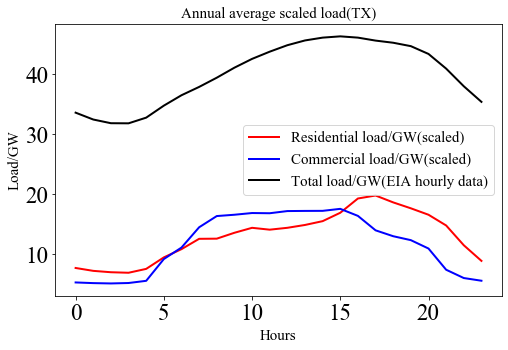

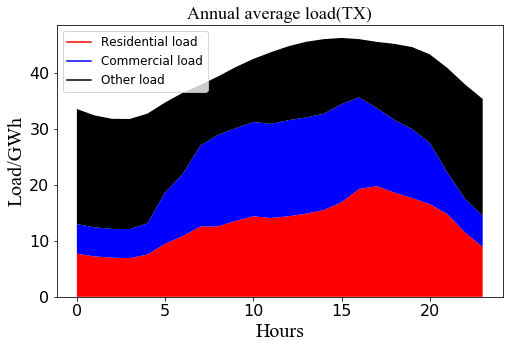

Scaled Commmercial ratio = 0.29442466073595225
Scaled Residential ratio = 0.3257160425163212
Scaled Other load ratio = 0.37985929674772656
Scaled Commmercial ratio = 0.3607156551370239
Scaled Residential ratio = 0.3434945346633103


In [30]:
systemload_average_all = systemload_new.groupby('hour').mean()
plot_Load_sectors_scaled(systemload_average_all,Region_list[region_id])
plot_Load_sectors_stack_scaled(systemload_average_all,Region_list[region_id])
# plot_Peak_yearly(systemload_new)

print('Scaled Commmercial ratio = '+str(systemload_average_all['scaled_com_kwh'].sum()/1000/systemload_average_all['Raw EIA load/MW'].sum()))
print('Scaled Residential ratio = '+str(systemload_average_all['scaled_res_kwh'].sum()/1000/systemload_average_all['Raw EIA load/MW'].sum()))
print('Scaled Other load ratio = '+str(systemload_average_all['scaled_other_load/KW'].sum()/1000/systemload_average_all['Raw EIA load/MW'].sum()))

print('Scaled Commmercial ratio = '+str(systemload_new['scaled_res_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))
print('Scaled Residential ratio = '+str(systemload_new['scaled_com_kwh_nighttime0'].sum()/1000/systemload_new['Daytime EIA load/MW'].sum()))

### 7.2 Plot the seasonal info

In [31]:
def plot_seasonly_average_load(CA_load_full):
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]

        CA_load_average = CA_load.groupby('hour').mean()


        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        figsize = 7,4.5
        figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load (scaled)/GW')
        plt.plot([],[], color='blue', label='Commercial load (scaled)/GW')
        plt.plot([],[], color='black', label='Other load (scaled)/GW')


        plt.stackplot(Hours, CA_load_average['scaled_res_kwh']/KWtoGW, \
                     CA_load_average['scaled_com_kwh']/KWtoGW,\
                      CA_load_average['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        
        title_name = 'Average load' + '(' + Region+ ', season = '+str(season_name) + ')'
        plt.legend(loc=2, prop={'size': 12})
        plt.tick_params(labelsize=16)
        plt.title(title_name,font1)
        plt.xlabel('Hours',font2)
        plt.ylabel('Load/GWh',font2)
        plt.show()
def plot_seasonly_peak_load(CA_load_full):
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        
        CA_load_weekend = CA_load[CA_load['weekend']==1]
        CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

        CA_load_weekday = CA_load[CA_load['weekend']==0]
        CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        figsize = 6,3.5
        figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load (scaled)/GW')
        plt.plot([],[], color='blue', label='Commercial load (scaled)/GW')
        plt.plot([],[], color='black', label='Other load (scaled)/GW')


        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        
        title_name = 'Peak load' + '(' + Region+ ', season = '+str(season_name) + ')'
        plt.legend(loc=2, prop={'size': 12})
        plt.tick_params(labelsize=16)
        plt.title(title_name,font1)
        plt.xlabel('Hours',font2)
        plt.ylabel('Load/GWh',font2)
        plt.show()
        
def plot_seasonly_peak_load_nolegend(CA_load_full):
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        
        CA_load_weekend = CA_load[CA_load['weekend']==1]
        CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

        CA_load_weekday = CA_load[CA_load['weekend']==0]
        CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        figsize = 6,3.5
        figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load/GW')
        plt.plot([],[], color='blue', label='Commercial load/GW')
        plt.plot([],[], color='black', label='Other load/GW')


        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        
        title_name = 'Peak load' + '(' + Region+ ', season = '+str(season_name) + ')'
        ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外

        plt.tick_params(labelsize=16)
        plt.title(title_name,font1)
        plt.xlabel('Hours',font2)
        plt.ylabel('Load/GWh',font2)
        plt.show()
        
def plot_seasonly_peak_load_integrated(CA_load_full,region):
    fig, ax_list = plt.subplots(2, 2, figsize=(10,8))
#     fig,ax = plt.subplots(nrows=2, ncols=2)
#     axes = ax.flatten()
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        
        CA_load_weekend = CA_load[CA_load['weekend']==1]
        CA_load_weekend_average = CA_load_weekend.groupby('hour').mean()

        CA_load_weekday = CA_load[CA_load['weekend']==0]
        CA_load_weekday_average = CA_load_weekday.groupby('hour').mean()

        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]

        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        print('Season = ' + str(season))
        
        plt.subplot(220+season)
#             df1.plot(ax=ax_list[0], legend=False)
#         figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load/GW')
        plt.plot([],[], color='blue', label='Commercial load/GW')
        plt.plot([],[], color='black', label='Other load/GW')


        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])
           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if season ==1 or season ==3:
            plt.ylabel('Load/GWh',font2)
        if season ==3 or season ==4:
            plt.xlabel('Hours',font2)
        if season ==1:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 60])
            my_y_ticks = np.arange(0, 61, 20)
            if season==1 or season==4:
                plt.text(18, 50, season_name)
            elif season==2 or season==3:
                plt.text(4, 50, season_name)
        if region == 'TX':
            plt.axis([0, 23, 0, 80]) 
            my_y_ticks = np.arange(0, 81, 20)
            plt.text(18, 70, season_name)
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 16, season_name)            
        
        plt.yticks(my_y_ticks)
        
    
    plt.show()
    
    
def plot_seasonly_average_load_integrated(CA_load_full,region):
    fig, ax_list = plt.subplots(2, 2, figsize=(10,8))
#     fig,ax = plt.subplots(nrows=2, ncols=2)
#     axes = ax.flatten()
    for season in range(1,5):
        if season ==1:
            season_name = 'Spring'
            CA_load = CA_load_full[(CA_load_full['month'] <= 3)]
        elif season ==2:
            season_name = 'Summer'
            CA_load = CA_load_full[(CA_load_full['month'] >= 4) & (CA_load_full['month'] >= 6)]
        elif season ==3:
            season_name = 'Autumn'
            CA_load = CA_load_full[(CA_load_full['month'] >= 7) & (CA_load_full['month'] >= 9)]
        elif season==4:
            season_name = 'Winter'
            CA_load = CA_load_full[(CA_load_full['month'] >= 10)]
        

        CA_load_average = CA_load.groupby('hour').mean()
        
        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        print('Season = ' + str(season))
        
        plt.subplot(220+season)
#             df1.plot(ax=ax_list[0], legend=False)
#         figure, ax = plt.subplots(figsize=figsize)
        plt.plot([],[], color='red', label='Residential load/GW')
        plt.plot([],[], color='blue', label='Commercial load/GW')
        plt.plot([],[], color='black', label='Other load/GW')


        plt.stackplot(Hours, CA_load_average['scaled_res_kwh']/KWtoGW, \
                     CA_load_average['scaled_com_kwh']/KWtoGW,\
                      CA_load_average['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])
           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if season ==1 or season ==3:
            plt.ylabel('Load/GWh',font2)
        if season ==3 or season ==4:
            plt.xlabel('Hours',font2)
        if season ==1:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 50])
            my_y_ticks = np.arange(0, 51, 10)
            if season==1 or season==4:
                plt.text(18, 45, season_name)
            elif season==2 or season==3:
                plt.text(4, 45, season_name)
        if region == 'TX':
            plt.axis([0, 23, 0, 60]) 
            my_y_ticks = np.arange(0, 61, 15)
            plt.text(18, 50, season_name)
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 16, season_name)    
        plt.yticks(my_y_ticks)
        

    plt.show()
    
    
def plot_monthly_average_load_integrated(CA_load_full,region,month_start, month_end):
    fig, ax_list = plt.subplots(2,3, figsize=(12,6))
    for month in range(month_start, month_end):
        
        CA_load = CA_load_full[(CA_load_full['month'] == month)]
        
        CA_load_average = CA_load.groupby('hour').mean()
        
        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]

        print('month = ' + str(month)+'(Month Average)')
        
        if month < 7:
            plt.subplot(230 + month)
        else:
            plt.subplot(230 + month-6)

        plt.plot([],[], color='red', label='R')
        plt.plot([],[], color='blue', label='C')
        plt.plot([],[], color='black', label='O')

        plt.stackplot(Hours, CA_load_average['scaled_res_kwh']/KWtoGW, \
                     CA_load_average['scaled_com_kwh']/KWtoGW,\
                      CA_load_average['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])
           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }


        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if month % 3  ==1: 
            plt.ylabel('Load/GWh',font2)
        if month > 9:
            plt.xlabel('Hours',font2)
        if month ==1 or month ==7:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 50])
            my_y_ticks = np.arange(0, 51, 10)
            plt.text(12, 45, str(month))

        if region == 'TX':
            plt.axis([0, 23, 0, 70]) 
            my_y_ticks = np.arange(0, 71, 15)
            plt.text(18, 60,  str(month))
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 18,  str(month)) 
        plt.yticks(my_y_ticks)

    plt.show()
    
    
    
def plot_monthly_peak_load_integrated(CA_load_full,region,month_start, month_end):
    fig, ax_list = plt.subplots(2,3, figsize=(12,6))
    
    for month in range(month_start, month_end):        
        CA_load = CA_load_full[(CA_load_full['month'] == month)]
        CA_load_peak_average = CA_load.groupby('day_of_year').mean()
        CA_load_peak_average_list = (CA_load_peak_average['Raw EIA load/MW'].tolist())

        day_year = CA_load_peak_average_list.index(max(CA_load_peak_average_list))
        day_year = CA_load_peak_average.index.tolist()[day_year]
        CA_load_peak = CA_load[CA_load['day_of_year']==day_year]
        
        KWtoGW = 1000000
        Hours= [x for x in range(0,24)]
        print('month = ' + str(month)+'(Month peak)')        
        if month < 7:
            plt.subplot(230 + month)
        else:
            plt.subplot(230 + month-6)

        plt.plot([],[], color='red', label='R')
        plt.plot([],[], color='blue', label='C')
        plt.plot([],[], color='black', label='O')

        plt.stackplot(Hours, CA_load_peak['scaled_res_kwh']/KWtoGW, \
                     CA_load_peak['scaled_com_kwh']/KWtoGW,\
                      CA_load_peak['scaled_other_load/KW']/KWtoGW,\
                      colors=['red','blue','black'])           

        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }

        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15,
        }
        if month % 3  ==1: 
            plt.ylabel('Load/GWh',font2)
        if month > 9:
            plt.xlabel('Hours',font2)
        if month ==1 or month ==7:
            plt.legend(loc='upper left') 
            
        if region == 'CA':
            plt.axis([0, 23, 0, 60])
            my_y_ticks = np.arange(0, 61, 10)
            plt.text(12, 55, str(month))

        if region == 'TX':
            plt.axis([0, 23, 0, 80]) 
            my_y_ticks = np.arange(0, 81, 15)
            plt.text(18, 70, str(month))    
        if region == 'NewEngland':
            plt.axis([0, 23, 0, 20]) 
            my_y_ticks = np.arange(0, 21, 5)
            plt.text(18, 18, str(month))     
        plt.yticks(my_y_ticks)

    plt.show()

In [32]:
# plot_seasonly_peak_load(systemload_new)
# plot_seasonly_peak_load_nolegend(systemload_new)
# plot_seasonly_average_load(systemload_new)

In [33]:
# plot_seasonly_average_load_integrated(systemload_new,Region)
# plot_seasonly_peak_load_integrated(systemload_new,Region)

month = 1(Month Average)
month = 2(Month Average)
month = 3(Month Average)
month = 4(Month Average)
month = 5(Month Average)
month = 6(Month Average)


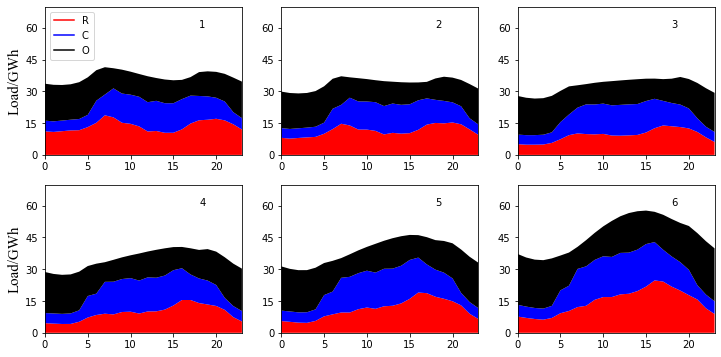

month = 7(Month Average)
month = 8(Month Average)
month = 9(Month Average)
month = 10(Month Average)
month = 11(Month Average)
month = 12(Month Average)


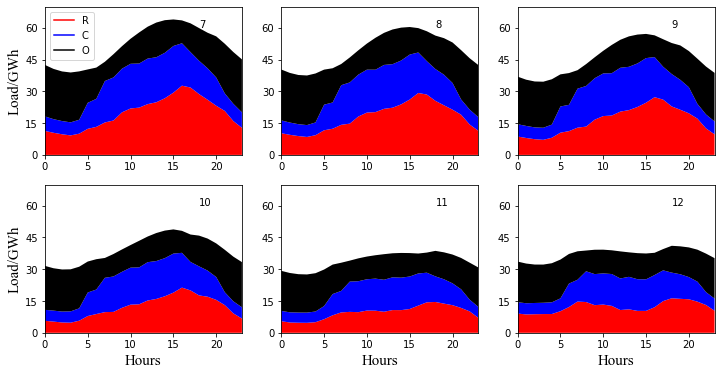

month = 1(Month peak)
month = 2(Month peak)
month = 3(Month peak)
month = 4(Month peak)
month = 5(Month peak)
month = 6(Month peak)


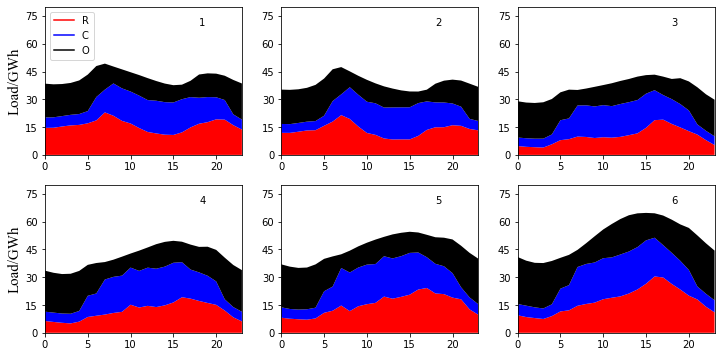

month = 7(Month peak)
month = 8(Month peak)
month = 9(Month peak)
month = 10(Month peak)
month = 11(Month peak)
month = 12(Month peak)


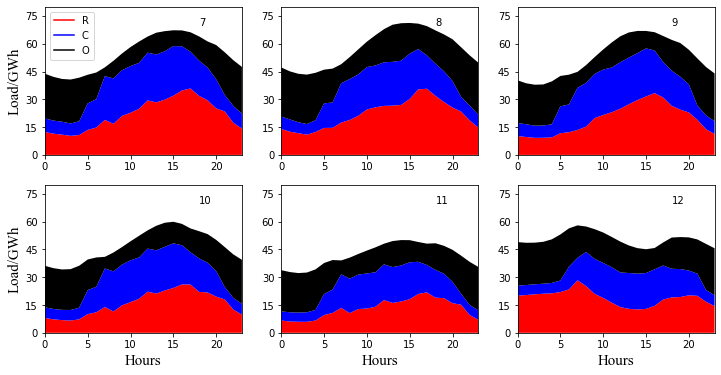

In [34]:
plot_monthly_average_load_integrated(systemload_new,Region,1,7)
plot_monthly_average_load_integrated(systemload_new,Region,7,13)
plot_monthly_peak_load_integrated(systemload_new,Region,1,7)
plot_monthly_peak_load_integrated(systemload_new,Region,7,13)

In [35]:
Region

'TX'

### 7.3 Plot the load duration curve


In [36]:
font1 = {'family':'Times New Roman','weight':'normal','size': 20}

In [37]:
# totalload_list_raw = systemload_new['Raw EIA load/MW'].tolist()
# a= sorted(totalload_list_raw, key=None, reverse=True)
# results_loadduration_sorted = pd.DataFrame()
# results_loadduration_sorted['Duration when load larger than left value(total,sorted)'] = range(1,len(a)+1)
# results_loadduration_sorted['Total load/MW'] = a
# results_loadduration_sorted.to_csv('Load duration reults(sorted).csv',index = False)
# figsize = 9,6
# figure, ax = plt.subplots(figsize=figsize)
# plt.plot(a,'b')
# plt.xlabel('Hours',font1)
# plt.ylabel('Load demand/MW',font1)
# plt.title('Load-Duration plot',font1)
# plt.tick_params(labelsize=20)
# plt.show()

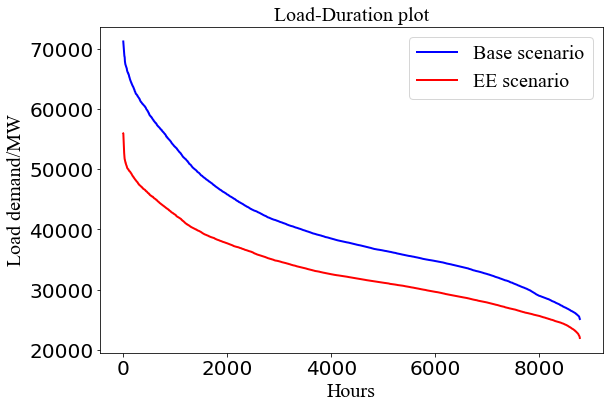

In [38]:
if Switch_EEconsidered==1:
    a= sorted(systemload_new['Raw EIA load/MW'].tolist(), key=None, reverse=True)
    b= sorted(systemload_new['EIA load consider EE/MW'].tolist(), key=None, reverse=True)

    figsize = 9,6
    figure, ax = plt.subplots(figsize=figsize)
    A, = plt.plot(a,'b',label='Base scenario',linewidth=2.0)
    B, = plt.plot(b,'r',label='EE scenario',linewidth=2.0)
    plt.xlabel('Hours',font1)
    plt.ylabel('Load demand/MW',font1)
    plt.title('Load-Duration plot',font1)
    plt.tick_params(labelsize=20)
    legend = plt.legend(handles=[A,B],prop=font1)
    plt.show()

In [39]:
if Switch_EEconsidered==1:
    k = 0.05
    a= sorted(systemload_new['Raw EIA load/MW'].tolist(), key=None, reverse=True)
    b= sorted(systemload_new['EIA load consider EE/MW'].tolist(), key=None, reverse=True)

    figsize = 9,6
    figure, ax = plt.subplots(figsize=figsize)
    A, = plt.plot(a,'b',label='Base scenario',linewidth=2.0)
    B, = plt.plot(b,'r',label='EE scenario',linewidth=2.0)
    plt.xlabel('Hours',font1)
    plt.ylabel('Load demand/MW',font1)
    plt.title('Load-Duration plot(' + Region + '_' + Keyword2+')',font1)
    plt.tick_params(labelsize=20)
    legend = plt.legend(handles=[A,B],prop=font1)
    
    y_base = np.linspace(min(b),a[int(k*len(a))],100)
    x_base = [int(len(a)*k) for y in y_base]
    C, =plt.plot(x_base, y_base, color='k', linestyle='-.',label='95%')  
    
    x_base = np.linspace(0,int(len(a)*k),100)
    y_base = [a[int(len(a)*k)] for x in x_base]
    plt.plot(x_base, y_base, color='b', linestyle='--') 
    plt.text(int(len(a)*k)+400, a[int(len(a)*k)]+1000, '%.0f' %(a[int(len(a)*k)]), ha='center', va= 'bottom',color = 'b',fontsize=15)
    plt.plot(int(len(a)*k), a[int(len(a)*k)], color='b', marker='o')

    y_base = [b[int(len(a)*k)] for x in x_base]
    plt.plot(x_base, y_base, color='r', linestyle='--')
    plt.text(int(len(a)*k)-1000, b[int(len(a)*k)]+500, '%.0f' %(b[int(len(a)*k)]), ha='center', va= 'bottom',color = 'r',fontsize=15)
    plt.plot(int(len(a)*k), b[int(len(a)*k)], color='r', marker='o')
    
    legend = plt.legend(handles=[A,B,C],prop=font1)    
    plt.axis([-10, len(a), min(b),max(a)*1.05])
    plt.show()    

### 7.4 Plot the load distribution

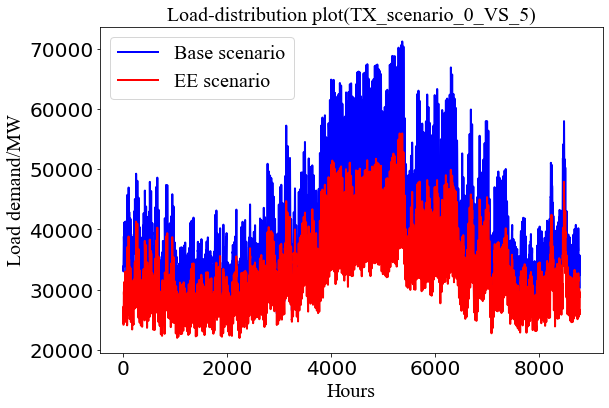

In [40]:

figsize = 9,6
figure, ax = plt.subplots(figsize=figsize)
A, = plt.plot(systemload_new['Raw EIA load/MW'].tolist(),'b',label='Base scenario',linewidth=2.0)
B, = plt.plot(systemload_new['EIA load consider EE/MW'].tolist(),'r',label='EE scenario',linewidth=2.0)
plt.xlabel('Hours',font1)
plt.ylabel('Load demand/MW',font1)
plt.title('Load-distribution plot(' + Region + '_' + Keyword2+')',font1)
plt.tick_params(labelsize=20)
legend = plt.legend(handles=[A,B],prop=font1)
plt.show()
    

### 7.5 Plot the hist of load distribution

In [41]:
# # matplotlib histogram
# from matplotlib.patches import Rectangle

# plt.hist(systemload_new['Raw EIA load/MW'], color = 'blue', edgecolor = 'black',
#          bins = int(100))
# plt.hist(systemload_new['EIA load consider EE/MW'], color = 'red', edgecolor = 'black',
#          bins = int(100))

# cmap = plt.get_cmap('jet')
# low = cmap(0.2)
# medium =cmap(0.8)

# handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,medium]]
# labels= ['Base scenario','EE scenario']
# plt.legend(handles, labels)

# plt.xlabel('Load demand/MW',font1)
# plt.ylabel('Hours',font1)
# plt.tick_params(labelsize=15)
# plt.title('Load distribution(' + Region+')',font1)

# plt.show()

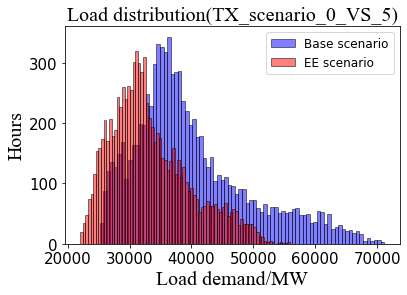

In [42]:
plt.hist(systemload_new['Raw EIA load/MW'],color = 'blue', bins=80, alpha=0.5, edgecolor = 'black',label='Base scenario')
plt.hist(systemload_new['EIA load consider EE/MW'], color = 'red', bins=80, alpha=0.5, edgecolor = 'black',label='EE scenario')
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('Load demand/MW',font1)
plt.ylabel('Hours',font1)
plt.tick_params(labelsize=15)
plt.title('Load distribution(' + Region + '_' + Keyword2+')',font1)
plt.show()

### 7.6 Plot the hist of load distribution

In [43]:
Base_list = systemload_new['Raw EIA load/MW'].tolist()
EE_list = systemload_new['EIA load consider EE/MW'].tolist()

Base_sorted_list = sorted(Base_list,reverse=True)
EE_sorted_list = sorted(EE_list,reverse=True)

In [44]:
result_BaseVSEE = pd.DataFrame(index=['Base','EE'])
result_BaseVSEE['Res load/GWh'] = [int(systemload_new.scaled_res_kwh.sum()/1000000),int(systemload_new.scaled_res_kwh_EE.sum()/1000000)]
result_BaseVSEE['Total load/GWh'] = [int(systemload_new['Raw EIA load/MW'].sum()/1000),int(systemload_new['EIA load consider EE/MW'].sum()/1000)]

result_BaseVSEE['Max load/MW'] = [int(max(Base_list)),int(max(EE_list))]
result_BaseVSEE['Min load/MW'] = [int(min(Base_list)),int(min(EE_list))]
result_BaseVSEE['Average load/MW'] = [int(np.mean(Base_list)),int(np.mean(EE_list))]
result_BaseVSEE['Median load/MW'] = [int(np.median(Base_list)),int(np.median(EE_list))]
result_BaseVSEE['Minimum load(Top95%)/MW'] = [int(Base_sorted_list[int(len(EE_list)*0.05)]),int(EE_sorted_list[int(len(EE_list)*0.05)])]
result_BaseVSEE['Average load(Top95%)/MW'] = [int(np.mean(Base_sorted_list[0:int(len(Base_list)*0.05)])),int(np.mean(EE_sorted_list[0:int(len(Base_list)*0.05)]))]

result_BaseVSEE['Max-Threshold(Top95%)/MW'] = [int(max(Base_list)-Base_sorted_list[int(len(EE_list)*0.05)]),int(max(EE_list)-EE_sorted_list[int(len(EE_list)*0.05)])]

result_BaseVSEE

Res load/GWh  Total load/GWh  Max load/MW  Min load/MW  Average load/MW  \
Base        114514          351578        71193        25146            40024   
EE           55621          292684        55937        21997            33320   

      Median load/MW  Minimum load(Top95%)/MW  Average load(Top95%)/MW  \
Base           37695                    60046                    63618   
EE             32023                    46348                    48741   

      Max-Threshold(Top95%)/MW  
Base                     11147  
EE                        9589

## 8. Read NREL file to generate the sum()

In [46]:
# import pyarrow.parquet as pq
# table2 = pq.read_table('Shared Drives/NREL_ResStock/results_up00.parquet')
# df_table2 = table2.to_pandas()
# df_table2.to_csv('Shared Drives/NREL_ResStock/results_up00.csv',index = False)

In [44]:
df_nrelstock_test1 = pd.read_csv('../Shared Drives/NREL_ResStock_Test/Test12_perbldgresults.csv')
df_nrelstock_test2 = pd.read_csv('../Shared Drives/NREL_ResStock_0306/LBNL run results.csv')

In [45]:
WS_list = []
UT_list = []
UG_list = []
EC_list = []
count = 0
for WS in df_nrelstock_test2['epw'].unique().tolist():
    count = count + 1
    print('This is the epw number ' + str(count) + ' /(36)')
    a = df_nrelstock_test2[df_nrelstock_test2['epw'] == WS]
    
    for UT in a['unit_type'].unique().tolist():
        b = a[a['unit_type'] == UT]
        
        for UG in df_nrelstock_test2['upgrade'].unique().tolist():
            WS_list.append(WS)
            UT_list.append(UT)
            UG_list.append(UG)            
            c = b[b['upgrade'] == UG]            
            EC_list.append(c['Building_Electricity'].sum())
            
result_ResStock = pd.DataFrame()
result_ResStock['epw'] = WS_list
result_ResStock['unit_type'] = UT_list
result_ResStock['upgrade'] = UG_list
result_ResStock['Building_Electricity sum'] = EC_list


This is the epw number 1 /(36)
This is the epw number 2 /(36)
This is the epw number 3 /(36)
This is the epw number 4 /(36)
This is the epw number 5 /(36)
This is the epw number 6 /(36)
This is the epw number 7 /(36)
This is the epw number 8 /(36)
This is the epw number 9 /(36)
This is the epw number 10 /(36)
This is the epw number 11 /(36)
This is the epw number 12 /(36)
This is the epw number 13 /(36)
This is the epw number 14 /(36)
This is the epw number 15 /(36)
This is the epw number 16 /(36)
This is the epw number 17 /(36)
This is the epw number 18 /(36)
This is the epw number 19 /(36)
This is the epw number 20 /(36)
This is the epw number 21 /(36)
This is the epw number 22 /(36)
This is the epw number 23 /(36)
This is the epw number 24 /(36)
This is the epw number 25 /(36)
This is the epw number 26 /(36)
This is the epw number 27 /(36)
This is the epw number 28 /(36)
This is the epw number 29 /(36)
This is the epw number 30 /(36)
This is the epw number 31 /(36)
This is the epw n

In [46]:
result_ResStock.to_csv('ResStock Result all-full.csv',index = False)
result_scalingfactor = result_ResStock[result_ResStock['upgrade']==0]
result_scalingfactor.index = range(len(result_ResStock[result_ResStock['upgrade']==0]))
result_scalingfactor.to_csv('For_ScalingFactor_begin.csv',index = False)

In [47]:
for epw in result_ResStock['epw'].unique().tolist():
    a = result_ResStock[result_ResStock['epw']==epw]
    
    for ut in a['unit_type'].unique().tolist():
        b = a[a['unit_type']==ut]
        c0 = b[b['upgrade']==0].iloc[0][3]
        c1 = b[b['upgrade']==1].iloc[0][3]
        c2 = b[b['upgrade']==2].iloc[0][3]
        c3 = b[b['upgrade']==3].iloc[0][3]
        c4 = b[b['upgrade']==4].iloc[0][3]
        c5 = b[b['upgrade']==5].iloc[0][3]
        if c0 ==max(c0,c1,c2,c3,c4,c5) and c5==min(c0,c1,c2,c3,c4,c5):
            pass
        else:
            print(epw + ' ' + ut )    

USA_CA_Bakersfield.Meadows.723840_2016.epw Mobile Home
USA_CA_Bakersfield.Meadows.723840_2016.epw Single-Family Attached
USA_CA_Barstow.Daggett.723815_2016.epw Single-Family Attached
USA_CA_Fresno.Air.Terminal.723890_2016.epw Single-Family Attached
USA_CA_Long.Beach.Lb.Airp.722970_2016.epw Mobile Home
USA_CA_Long.Beach.Lb.Airp.722970_2016.epw Multi-Family with 2 - 4 Units
USA_CA_Long.Beach.Lb.Airp.722970_2016.epw Multi-Family with 5+ Units
USA_CA_Long.Beach.Lb.Airp.722970_2016.epw Single-Family Attached
USA_CA_Long.Beach.Lb.Airp.722970_2016.epw Single-Family Detached
USA_CA_Los.Angeles.Intl.722950_2016.epw Mobile Home
USA_CA_Los.Angeles.Intl.722950_2016.epw Multi-Family with 2 - 4 Units
USA_CA_Los.Angeles.Intl.722950_2016.epw Multi-Family with 5+ Units
USA_CA_Los.Angeles.Intl.722950_2016.epw Single-Family Attached
USA_CA_Los.Angeles.Intl.722950_2016.epw Single-Family Detached
USA_CA_San.Francisco.Intl.724940_2016.epw Single-Family Attached
USA_CA_Santa.Maria.Public.723940_2016.epw Mult

## 9. Check the NREL result whether the anverage load = sum(each end user)
## Generate the ratio for one sample epw

In [48]:
df_nrelstock_test = df_nrelstock_test2.copy()

WS = 'USA_CA_San.Francisco.Intl.724940_2016.epw'
aa = df_nrelstock_test[df_nrelstock_test['epw'] == WS]
Build_category = 'Mobile Home'

for ut in aa['unit_type'].unique().tolist():
    bb = aa[aa['unit_type']== ut]
    cc = bb[bb['upgrade'] == 0] 

    end_use_sum = 0
    end_use_list = []
    load_KWh_list = []
    ratio_list = []
    cum_ratio_list = []

    total_build_load = cc['Building_Electricity'].sum()
    for cate in cc.columns.tolist()[4:]:
        if cate=='Interior_Equipment':
            pass
        elif cate=='Building_Electricity':
            end_use_list.append(cate)
            load_KWh_list.append(total_build_load)
            ratio_list.append(100)
            cum_ratio_list.append(100)
        else:
            temp_end_cum = cc[cate].sum()
            end_use_sum = end_use_sum + temp_end_cum
            end_use_list.append(cate)
            load_KWh_list.append(temp_end_cum)
            ratio_list.append(temp_end_cum/total_build_load*100)
            cum_ratio_list.append(end_use_sum/total_build_load*100)

    result_enduse = pd.DataFrame()
    result_enduse['End use type'] = end_use_list
    result_enduse['Cumu_load_KWh'] = load_KWh_list
    result_enduse['End use Ratio/%'] = ratio_list
    result_enduse['End use Ratio(Cumulative)/%'] = cum_ratio_list
    result_enduse.to_csv('Result_enduseRatio_'+ ut + '('+ WS +').csv',index = False)

    gap = end_use_sum - cc['Building_Electricity'].sum()
    if gap <0.01:
        print('Matched(' + ut + ')')
        print('    Absolute gap value is: ' + str(gap))

Matched(Mobile Home)
    Absolute gap value is: -3.637978807091713e-12
Matched(Multi-Family with 2 - 4 Units)
    Absolute gap value is: -9.094947017729282e-13
Matched(Multi-Family with 5+ Units)
    Absolute gap value is: -2.7284841053187847e-12
Matched(Single-Family Attached)
    Absolute gap value is: -9.094947017729282e-13
Matched(Single-Family Detached)
    Absolute gap value is: 3.637978807091713e-12


# 10 For test (2535 spike)

In [49]:
# yearly_data3 = yearly_data.copy()
# yearly_data4 = yearly_data3[(yearly_data3['Time_dateframe'] >= '2016-1-1') & (yearly_data3['Time_dateframe'] <= '2017-01-01')]
# yearly_data4.index = range(len(yearly_data4))
# yearly_data4.to_csv('For debug.csv')

# 11. Check the consistance 

In [50]:
if Region =='CA':
    raw = pd.read_csv('demo_gross_load_CA_LHComb.csv')
    delta = list(map(lambda x: x[0] - x[1], zip(systemload_new['Raw EIA load/MW'].tolist()[0:-1],raw['Raw EIA load/MW'].tolist()[1:])))
    plt.plot(delta)
    plt.show()
    a = systemload_new['scaled_res_kwh_nighttime0'].sum()/(systemload_new['Daytime EIA load/MW'].sum())
    b = raw['scaled_res_kwh_nighttime0'].sum()/(raw['Daytime EIA load/MW'].sum())
    print(a/1000)
    print(abs(a/b - 1) <=0.0001)
else:
    a = systemload_new['scaled_res_kwh_nighttime0'].sum()/(systemload_new['Daytime EIA load/MW'].sum())
    print(abs(a/1000-K_Res) <=0.0001)

FileNotFoundError: [Errno 2] File b'demo_gross_load_CA_LHComb.csv' does not exist: b'demo_gross_load_CA_LHComb.csv'

# 12. Check the aggregated end use ratio
## 12.1 Calculate the aggregated load based on the scaling factors

In [ ]:
df_scaling_factor=pd.read_csv('ScaldingFactor(Full_ResStock_Data)_'+Region+'.csv')
# df_scaling_factor = df_ScalingFactor.copy()
result = pd.DataFrame()
result['Date/Time'] = systemload_new['Date/Time']
result.index = systemload_new.index
    
for upgrade in [0,1,2,3,4,5]:
    print('======This is upgrade ' + str(upgrade) + ' /(5)'+'=====')
    df_nrelstock_test_0 = df_nrelstock_test2[df_nrelstock_test2['upgrade'] == upgrade]
    count = 0
    cum_count = 0
    for WS in df_nrelstock_test_0['epw'].unique().tolist():
        count = count + 1
        if count % 6 ==0:
            print('This is the epw number ' + str(count) + ' /(36)')
        a = df_nrelstock_test_0[df_nrelstock_test_0['epw'] == WS]

        for UT in a['unit_type'].unique().tolist():
            cum_count = cum_count + 1
            b = a[a['unit_type'] == UT]

            tem_a = df_scaling_factor[df_scaling_factor['epw']==WS]
            tem_b = tem_a[tem_a['unit_type']==UT]
            factor = tem_b.iloc[0][4]*tem_b.iloc[0][5]*tem_b.iloc[0][6]

            for end_use in a.columns.tolist()[4:]:
                if cum_count ==1:
                    result[end_use] = [x*factor for x in b[end_use].tolist()]
                else:
                    result[end_use] = list(map(lambda x:x[0]+x[1]*factor, zip(result[end_use].tolist(),b[end_use].tolist())))

    cc = result.copy()
    end_use_sum = 0
    end_use_list = []
    load_KWh_list = []
    ratio_list = []
    cum_ratio_list = []

    total_build_load = cc['Building_Electricity'].sum()
    for cate in cc.columns.tolist()[1:]:
        if cate=='Interior_Equipment':
            pass
        elif cate=='Building_Electricity':
            end_use_list.append(cate)
            load_KWh_list.append(total_build_load)
            ratio_list.append(100)
            cum_ratio_list.append(100)
        else:
            temp_end_cum = cc[cate].sum()
            end_use_sum = end_use_sum + temp_end_cum
            end_use_list.append(cate)
            load_KWh_list.append(temp_end_cum)
            ratio_list.append(temp_end_cum/total_build_load*100)
            cum_ratio_list.append(end_use_sum/total_build_load*100)
    if upgrade ==0:
        result_enduse = pd.DataFrame()
        result_enduse['End use type'] = end_use_list
    result_enduse['Cumu_load_KWh(Upgrade='+str(upgrade)+')'] = load_KWh_list
    result_enduse['End use percentage(Upgrade='+str(upgrade)+')']= ratio_list
    result_enduse['End use percentage(Cumulative-Upgrade='+str(upgrade)+')']= cum_ratio_list


    gap = end_use_sum - cc['Building_Electricity'].sum()
    if abs(gap) <0.01:
        print('    Matched(upgrade ' + str(upgrade) + ')')
        print('    Absolute gap value is: ' + str(gap))
    else:
        print('    ======Not Matched(upgrade ' + str(upgrade) + ')')
        print('    ======Absolute gap value is: ' + str(gap))    
result_enduse.to_csv('Result_EnduseRatio' + '(Aggregated-TX).csv')    
end1 = datetime.datetime.now()
# print(end1-start1)

## 12.2 Plot the end-use ratio 

In [ ]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}

In [ ]:
result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-CA).csv')
figsize = 9,6
figure, ax = plt.subplots(figsize=figsize)
for upgrade in [0,1,2,3,4,5]:
    plt.plot(range(1,33),result_enduse['End use percentage(Upgrade='+str(upgrade)+')'].tolist()[1:],label = 'upgrade' + str(upgrade))

plt.legend(loc=0, prop={'size': 12})
plt.xlabel('End-use types(CA)',font1)
plt.ylabel('Percentage/%',font1)
plt.tick_params(labelsize=15)

In [ ]:
result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-TX).csv')
figsize = 9,6
figure, ax = plt.subplots(figsize=figsize)
for upgrade in [0,1,2,3,4,5]:
    plt.plot(range(1,33),result_enduse['End use percentage(Upgrade='+str(upgrade)+')'].tolist()[1:],label = 'upgrade' + str(upgrade))

plt.legend(loc=0, prop={'size': 12})
plt.xlabel('End-use types(TX)',font1)
plt.ylabel('Percentage/%',font1)
plt.tick_params(labelsize=15)

In [ ]:
systemload_new = pd.read_csv('Gross_load_CA_scenario_0_VS_5.csv')
result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-CA).csv')  
print('The average residential load(CA-final) is ' + str(systemload_new['scaled_res_kwh'].sum()/1000000/366/24))
print('The average residential load(CA-using scaling) is ' + str(result_enduse['Cumu_load_KWh(Upgrade=0)'].sum()/1000000/366/24))

In [ ]:
systemload_new = pd.read_csv('Gross_load_TX_scenario_0_VS_5.csv')
result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-TX).csv')  
print('The average residential load(TX-final) is ' + str(systemload_new['scaled_res_kwh'].sum()/1000000/366/24))
print('The average residential load(TX-using scaling) is ' + str(result_enduse['Cumu_load_KWh(Upgrade=0)'].sum()/1000000/366/24))

In [ ]:
sum(yearly_data_list_raw)/366/24/1000